# Marc EDA Notebook

* I am going to take the cleaned up information that Nick and I ended up with and explore on it.

In [3]:
import sys
print(sys.path)

['/Users/marc_aradillas/codeup-data-science/New-York-health-Inspection-Prediction/marc-folder', '/opt/homebrew/anaconda3/lib/python310.zip', '/opt/homebrew/anaconda3/lib/python3.10', '/opt/homebrew/anaconda3/lib/python3.10/lib-dynload', '', '/opt/homebrew/anaconda3/lib/python3.10/site-packages', '/opt/homebrew/anaconda3/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-macosx-11.1-arm64.egg']


In [4]:
# import libs
import acquire as a
import prepare as p
import pandas as pd
# I may come up with model and explore .py modules

# Data Acquisition

### We acquired from the Open Data new york using the Socrata API and saw our observations/features

In [3]:
ny_df = a.acquire_ny()
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207929 entries, 0 to 207928
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  207929 non-null  int64  
 1   dba                    207421 non-null  object 
 2   boro                   207929 non-null  object 
 3   building               207578 non-null  object 
 4   street                 207923 non-null  object 
 5   zipcode                205249 non-null  float64
 6   phone                  207922 non-null  object 
 7   inspection_date        207929 non-null  object 
 8   critical_flag          207929 non-null  object 
 9   record_date            207929 non-null  object 
 10  latitude               207672 non-null  float64
 11  longitude              207672 non-null  float64
 12  community_board        204682 non-null  float64
 13  council_district       204678 non-null  float64
 14  census_tract           204678 non-nu

In [4]:
ny_df.describe()

,camis,zipcode,latitude,longitude,community_board,council_district,census_tract,bin,bbl,score
count,2.079290e+05,205249.000000,207672.000000,207672.000000,204682.000000,204678.000000,204678.000000,2.036920e+05,2.073560e+05,198223.000000
mean,4.754730e+07,10708.297531,40.202137,-72.989116,254.466377,20.829606,30102.818036,2.575328e+06,2.463837e+09,22.745595
std,4.030975e+06,594.575056,4.592017,8.336484,129.962408,15.822260,31625.361472,1.345550e+06,1.336137e+09,17.508178
min,3.007544e+07,8512.000000,0.000000,-74.249101,101.000000,1.000000,100.000000,1.000000e+06,1.000000e+00,0.000000
25%,4.164752e+07,10023.000000,40.682891,-73.988840,106.000000,4.000000,8000.000000,1.050759e+06,1.010898e+09,11.000000
50%,5.006672e+07,11101.000000,40.730123,-73.956354,302.000000,20.000000,17500.000000,3.021815e+06,3.007980e+09,19.000000
75%,5.010666e+07,11231.000000,40.760953,-73.896137,401.000000,34.000000,42600.000000,4.006920e+06,4.004711e+09,30.000000
max,5.014367e+07,12345.000000,40.912822,0.000000,595.000000,51.000000,162100.000000,5.799501e+06,5.270001e+09,168.000000


In [5]:
ny_df.head()

,camis,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,...,bbl,nta,cuisine_description,action,violation_code,violation_description,score,grade,grade_date,inspection_type
0,50106756,UNGARO COAL FIRED PIZZA CAFE,Staten Island,1298,FOREST AVENUE,10302.0,6464690930,1900-01-01T00:00:00.000,Not Applicable,2023-10-26T06:00:14.000,...,5.003870e+09,SI07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50105716,STELLA'S,Brooklyn,559,5 AVENUE,11215.0,4155703174,1900-01-01T00:00:00.000,Not Applicable,2023-10-26T06:00:14.000,...,3.010480e+09,BK37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41168748,DUNKIN,Bronx,880,GARRISON AVENUE,10474.0,7188614171,2022-03-30T00:00:00.000,Not Critical,2023-10-26T06:00:11.000,...,2.027390e+09,BX27,Donuts,Violations were cited in the following area(s).,10J,Hand wash sign not posted,13.0,A,2022-03-30T00:00:00.000,Cycle Inspection / Initial Inspection
3,50131566,EXTACY LOUNGE,Queens,7701,JAMAICA AVE,11421.0,3478752367,1900-01-01T00:00:00.000,Not Applicable,2023-10-26T06:00:14.000,...,4.088410e+09,QN53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50128764,RUNNING KIDS,Brooklyn,856,64 STREET,11220.0,7188338856,1900-01-01T00:00:00.000,Not Applicable,2023-10-26T06:00:14.000,...,3.057420e+09,BK34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- We cleaned up the data by handling all null values, Most nulls were dropped, grades were just adjusted according to score.
- Nick is currently wanting to accomplish the following:
    - ***"I want to consolidate the data down to one row per inspection. Currently there are multiple rows per violation per inspection. I would like to merge each row per inspection down to one row."***
    - ***"Having some difficulties combining rows. I have managed to have some progress using group by along with some aggregate functions. Need to check if combined data is accurate."***

# Data Preparation

- Changes:
    - Function uses an additional line of code that resets index after clean actions.

In [6]:
ny = p.clean_ny(ny_df)

In [7]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198289 entries, 0 to 198288
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  198289 non-null  int64  
 1   dba                    198289 non-null  object 
 2   boro                   198289 non-null  object 
 3   building               198289 non-null  object 
 4   street                 198289 non-null  object 
 5   zipcode                198289 non-null  int64  
 6   phone                  198289 non-null  object 
 7   inspection_date        198289 non-null  object 
 8   record_date            198289 non-null  object 
 9   latitude               198289 non-null  float64
 10  longitude              198289 non-null  float64
 11  cuisine_description    198289 non-null  object 
 12  action                 198289 non-null  object 
 13  violation_code         198289 non-null  object 
 14  violation_description  198289 non-nu

In [8]:
ny.describe()

,camis,zipcode,latitude,longitude,score
count,1.982890e+05,198289.000000,198289.000000,198289.000000,198289.000000
mean,4.749308e+07,10573.075481,40.202635,-72.990846,22.702989
std,4.056105e+06,1343.223260,4.588263,8.329762,17.526276
min,3.007544e+07,0.000000,0.000000,-74.248708,0.000000
25%,4.163804e+07,10022.000000,40.682327,-73.988899,11.000000
50%,5.006457e+07,11101.000000,40.729928,-73.956452,19.000000
75%,5.010589e+07,11230.000000,40.760760,-73.896122,30.000000
max,5.014318e+07,12345.000000,40.912822,0.000000,168.000000


### No nulls

In [9]:
ny.isna().sum()

camis                    0
dba                      0
boro                     0
building                 0
street                   0
zipcode                  0
phone                    0
inspection_date          0
record_date              0
latitude                 0
longitude                0
cuisine_description      0
action                   0
violation_code           0
violation_description    0
score                    0
grade                    0
dtype: int64

In [10]:
ny.nunique()

camis                    25820
dba                      20593
boro                         5
building                  7249
street                    2256
zipcode                    221
phone                    23872
inspection_date           1613
record_date                  2
latitude                 21802
longitude                21802
cuisine_description         89
action                       4
violation_code              73
violation_description      151
score                      130
grade                        3
dtype: int64

### concatenating the address features together to have a full address column

In [11]:
full_addy = ny.building + ' ' + ny.street + ' ' + ny.zipcode.astype(str)
ny['full_address'] = full_addy

In [12]:
ny['full_address'][0:5]

0      880 GARRISON AVENUE 10474
1      620 ATLANTIC AVENUE 11217
2            8711 3 AVENUE 11209
3          58 MARCY AVENUE 11211
4    2492 LINDEN BOULEVARD 11208
Name: full_address, dtype: object

- dropped the old address features

In [13]:
ny = ny.drop(columns=['building', 'street', 'zipcode'])

In [14]:
ny.columns

Index(['camis', 'dba', 'boro', 'phone', 'inspection_date', 'record_date',
       'latitude', 'longitude', 'cuisine_description', 'action',
       'violation_code', 'violation_description', 'score', 'grade',
       'full_address'],
      dtype='object')

### Now I am looking at the inspections dates for cleaning

In [15]:
ny.inspection_date.nunique()

1613

## Grouped by camis and inspection_date and then aggregated violation_code and violation description to lists for respective camis/inspection date observation

In [16]:
agg_violations = ny.groupby(['camis','inspection_date']).agg({'violation_code': lambda x: x.tolist(),'violation_description':lambda x: x.tolist()})
agg_violations[0:2]

violation_code  \
camis    inspection_date                                                     
30075445 2021-08-10T00:00:00.000                                     [06E]   
         2023-01-31T00:00:00.000  [04H, 08C, 04L, 10D, 10F, 06C, 04N, 06D]   

                                                              violation_description  
camis    inspection_date                                                             
30075445 2021-08-10T00:00:00.000  [Sanitized equipment or utensil, including in-...  
         2023-01-31T00:00:00.000  [Raw, cooked or prepared food is adulterated, ...

## Looks good

In [17]:
# location a specific aggregated violation with specific camis and date
agg_violations.loc[(30075445, '2021-08-10T00:00:00.000')]

violation_code                                                       [06E]
violation_description    [Sanitized equipment or utensil, including in-...
Name: (30075445, 2021-08-10T00:00:00.000), dtype: object

## added the codes and descritpion into a list and them appended then to the location for each group (camis/date combination)

In [18]:
agg_data_code = []
agg_data_description = []

for cam, date in zip(ny.camis, ny.inspection_date):
    agg_data_code.append(agg_violations.loc[(cam, date)][0])
    agg_data_description.append(agg_violations.loc[(cam, date)][1])
    
ny.violation_code = agg_data_code
ny.violation_description = agg_data_description

/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_16199/625493721.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  agg_data_code.append(agg_violations.loc[(cam, date)][0])
/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_16199/625493721.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  agg_data_description.append(agg_violations.loc[(cam, date)][1])


## Look at first 3 to see changes 

In [19]:
ny.head(3)

,camis,dba,boro,phone,inspection_date,record_date,latitude,longitude,cuisine_description,action,violation_code,violation_description,score,grade,full_address
0,41168748,DUNKIN,Bronx,7188614171,2022-03-30T00:00:00.000,2023-10-26T06:00:11.000,40.816753,-73.892364,Donuts,Violations cited,"[10J, 04N, 08A]","[Hand wash sign not posted, Filth flies or foo...",13.0,A,880 GARRISON AVENUE 10474
1,41688142,TABLE 87,Brooklyn,9176186100,2017-01-25T00:00:00.000,2023-10-26T06:00:11.000,40.683447,-73.975691,Pizza,No violations,[No violation],[No violation],0.0,A,620 ATLANTIC AVENUE 11217
2,50100336,SUBWAY,Brooklyn,7186808808,2022-04-05T00:00:00.000,2023-10-26T06:00:11.000,40.622569,-74.031412,Sandwiches,Violations cited,"[09B, 10F, 06D]","[Thawing procedures improper., Non-food contac...",10.0,A,8711 3 AVENUE 11209


## sorting by inspection dates to see if multiple dates are listed for a specific business: this look like it worked we can see the lists in the violation code/description columns

In [20]:
ny[ny.dba == '$1 PIZZA'].sort_values('inspection_date').head(3)

,camis,dba,boro,phone,inspection_date,record_date,latitude,longitude,cuisine_description,action,violation_code,violation_description,score,grade,full_address
146736,50086385,$1 PIZZA,Manhattan,9175878888,2022-02-22T00:00:00.000,2023-10-26T06:00:11.000,40.746510,-73.990158,Pizza,Violations cited,[02B],[Hot food item not held at or above 140º F.],7.0,A,832 6 AVENUE 10001
162273,50117047,$1 PIZZA,Manhattan,9173883956,2022-05-04T00:00:00.000,2023-10-26T06:00:11.000,40.731409,-74.001176,Pizza,Violations cited,"[06B, 02B, 04A, 06C]","[Tobacco use, eating, or drinking from open co...",0.0,A,333B AVENUE OF THE AMERICAS 10014
150519,50117047,$1 PIZZA,Manhattan,9173883956,2022-05-04T00:00:00.000,2023-10-26T06:00:11.000,40.731409,-74.001176,Pizza,Violations cited,"[06B, 02B, 04A, 06C]","[Tobacco use, eating, or drinking from open co...",0.0,A,333B AVENUE OF THE AMERICAS 10014


In [21]:
agg_violations.index[0]

(30075445, '2021-08-10T00:00:00.000')

In [22]:
len(agg_data_code)

198289

In [23]:
ny.groupby('dba').camis.nunique()

dba
"U" LIKE CHINESE TAKE OUT           1
"W" CAFE                            1
#1 GARDEN CHINESE RESTAURANT        1
#1 SABOR LATINO RESTAURANT          1
$1 PIZZA                            2
                                   ..
jackies best italian pizza llc      1
kampai hibachi & brazilian Grill    1
kokomo restaurant                   1
matchpointnyc                       1
mukbang                             1
Name: camis, Length: 20593, dtype: int64

In [24]:
ny.head(3)

,camis,dba,boro,phone,inspection_date,record_date,latitude,longitude,cuisine_description,action,violation_code,violation_description,score,grade,full_address
0,41168748,DUNKIN,Bronx,7188614171,2022-03-30T00:00:00.000,2023-10-26T06:00:11.000,40.816753,-73.892364,Donuts,Violations cited,"[10J, 04N, 08A]","[Hand wash sign not posted, Filth flies or foo...",13.0,A,880 GARRISON AVENUE 10474
1,41688142,TABLE 87,Brooklyn,9176186100,2017-01-25T00:00:00.000,2023-10-26T06:00:11.000,40.683447,-73.975691,Pizza,No violations,[No violation],[No violation],0.0,A,620 ATLANTIC AVENUE 11217
2,50100336,SUBWAY,Brooklyn,7186808808,2022-04-05T00:00:00.000,2023-10-26T06:00:11.000,40.622569,-74.031412,Sandwiches,Violations cited,"[09B, 10F, 06D]","[Thawing procedures improper., Non-food contac...",10.0,A,8711 3 AVENUE 11209


In [25]:
ny.shape

(198289, 15)

## We need to ensure datatypes are correct

In [26]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198289 entries, 0 to 198288
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  198289 non-null  int64  
 1   dba                    198289 non-null  object 
 2   boro                   198289 non-null  object 
 3   phone                  198289 non-null  object 
 4   inspection_date        198289 non-null  object 
 5   record_date            198289 non-null  object 
 6   latitude               198289 non-null  float64
 7   longitude              198289 non-null  float64
 8   cuisine_description    198289 non-null  object 
 9   action                 198289 non-null  object 
 10  violation_code         198289 non-null  object 
 11  violation_description  198289 non-null  object 
 12  score                  198289 non-null  float64
 13  grade                  198289 non-null  object 
 14  full_address           198289 non-nu

## There were 89 NaN values for phone, so i will input a string for these and list them as 'no phone'

In [27]:
# # Convert a numeric column to numeric type (float)
# ny['phone'] = pd.to_numeric(ny['phone'], errors='coerce')

# # Convert it to an integer
# ny['phone'] = ny['phone'].astype(int)

# # Check the data type of the column after conversion
# print(ny['phone'].dtype)

In [28]:
ny[ny['phone'].isna()].shape

(0, 15)

In [29]:
ny[ny['phone'].isna()]

,camis,dba,boro,phone,inspection_date,record_date,latitude,longitude,cuisine_description,action,violation_code,violation_description,score,grade,full_address


In [30]:
# Replace NaN values in the 'phone' column with No Phone place holder
ny['phone'].fillna(-1, inplace=True)  # Use -1 as a numeric placeholder for missing phone numbers

# Check to verify that NaN values have been replaced
print(ny['phone'])

0         7188614171
1         9176186100
2         7186808808
3         7186360902
4         7182729090
             ...    
198284    7182973450
198285    6464921148
198286    2123672192
198287    2124803880
198288    7185958192
Name: phone, Length: 198289, dtype: object


In [31]:
# Convert inspection_date to datetime
ny['inspection_date'] = pd.to_datetime(ny['inspection_date'])

# Convert record_date to datetime
ny['record_date'] = pd.to_datetime(ny['record_date'])

# Convert score to numeric (float)
ny['score'] = pd.to_numeric(ny['score'], errors='coerce')  # 'coerce' to handle non-numeric values

# Convert grade to categorical
ny['grade'] = pd.Categorical(ny['grade'])

# Convert other object columns to appropriate data types as needed
# For example, if 'phone' should be treated as a string, no further conversion is necessary

# Check data types of the DataFrame after conversion
print(ny.dtypes)

camis                             int64
dba                              object
boro                             object
phone                            object
inspection_date          datetime64[ns]
record_date              datetime64[ns]
latitude                        float64
longitude                       float64
cuisine_description              object
action                           object
violation_code                   object
violation_description            object
score                           float64
grade                          category
full_address                     object
dtype: object


In [32]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198289 entries, 0 to 198288
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   camis                  198289 non-null  int64         
 1   dba                    198289 non-null  object        
 2   boro                   198289 non-null  object        
 3   phone                  198289 non-null  object        
 4   inspection_date        198289 non-null  datetime64[ns]
 5   record_date            198289 non-null  datetime64[ns]
 6   latitude               198289 non-null  float64       
 7   longitude              198289 non-null  float64       
 8   cuisine_description    198289 non-null  object        
 9   action                 198289 non-null  object        
 10  violation_code         198289 non-null  object        
 11  violation_description  198289 non-null  object        
 12  score                  198289 non-null  floa

## Flattened the DF in case Nick wants to use it.

## - This has almost 5 Million observations to explore

In [33]:
# # copy of the original DataFrame
# flattened_ny = ny.copy()

# # Explode the lists in 'violation_code' and 'violation_description' columns
# flattened_ny = flattened_ny.explode('violation_code').explode('violation_description')

# # Reset the index to ensure unique row identifiers
# flattened_ny = flattened_ny.reset_index(drop=True)

In [34]:
# flattened_ny.info()

In [35]:
# print(flattened_ny.shape)
# print('\n\n\n')
# flattened_ny.head()

<!-- ## John Requested Matching Criteria   -->

# Exploratory Data Analysis - Statistical Analysis

In [13]:
# ny = a.acquire_ny()
# ny = p.final_ny()

In [14]:
ny = pd.read_csv('clean_ny.csv')

In [ ]:
## Here I am using the cleaned dataframe

In [16]:
# datetime needs to be applied to date time data
ny['inspection_date'] = pd.to_datetime(ny['inspection_date'])

In [17]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60825 entries, 0 to 60824
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   camis                  60825 non-null  int64         
 1   dba                    60825 non-null  object        
 2   boro                   60825 non-null  object        
 3   phone                  60825 non-null  int64         
 4   inspection_date        60825 non-null  datetime64[ns]
 5   latitude               60825 non-null  float64       
 6   longitude              60825 non-null  float64       
 7   cuisine_description    60825 non-null  object        
 8   action                 60825 non-null  object        
 9   score                  60825 non-null  int64         
 10  grade                  60825 non-null  object        
 11  full_address           60825 non-null  object        
 12  violation_code         60825 non-null  object        
 13  v

In [9]:
ny.head()

,camis,dba,boro,building,street,zipcode,phone,inspection_date,record_date,latitude,longitude,cuisine_description,action,score,grade,violation_code,violation_description
0,41168748,DUNKIN,Bronx,880,GARRISON AVENUE,10474,7.188614e+09,2022-03-30,2023-10-26T06:00:11.000,40.816753,-73.892364,Donuts,Violations cited,13.0,A,10J 04N 08A,Hand wash sign not posted Filth flies or food/...
1,41688142,TABLE 87,Brooklyn,620,ATLANTIC AVENUE,11217,9.176186e+09,2017-01-25,2023-10-26T06:00:11.000,40.683447,-73.975691,Pizza,No violations,0.0,A,No violation,No violation
2,50100336,SUBWAY,Brooklyn,8711,3 AVENUE,11209,7.186809e+09,2022-04-05,2023-10-26T06:00:11.000,40.622569,-74.031412,Sandwiches,Violations cited,10.0,A,09B 10F 06D,Thawing procedures improper. Non-food contact ...
3,50086686,GERTIE,Brooklyn,58,MARCY AVENUE,11211,7.186361e+09,2021-08-25,2023-10-26T06:00:13.000,40.712360,-73.955419,American,No violations,0.0,A,No violation,No violation
4,50081121,DUNKIN,Brooklyn,2492,LINDEN BOULEVARD,11208,7.182729e+09,2022-04-04,2023-10-26T06:00:11.000,40.666827,-73.871606,Donuts,Violations cited,24.0,B,10J 02G 04N 10F 08A,Hand wash sign not posted Cold food item held ...


## Installed Plotly for interactive visuals

In [10]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [18]:
# visual imports
import seaborn as sns
import matplotlib.pyplot as plt
import plotly

import numpy as np

## Doing some seaborn exploration

  * note that I am using the flattened_ny dataframe due to data not being able to be visualized with list values for violation code/description column

In [19]:
# # should drop lat and long; don't need to see them
# ny = ny.drop(columns=(['latitude', 'longitude']))

# # Separate columns into numeric and categorical types
# numeric_columns = ny.select_dtypes(include=['int64', 'float64']).columns
# categorical_columns = ny.select_dtypes(include=['object']).columns

# # Visualize numeric features (e.g., histograms)
# for column in numeric_columns:
#     plt.figure()
#     sns.histplot(ny[column])
#     plt.title(f'Distribution of {column}')
#     plt.show()

# # Visualize categorical features (e.g., bar plots)
# for column in categorical_columns:
#     plt.figure(figsize=(10, 5))
#     sns.countplot(data=ny, x=column)
#     plt.title(f'Distribution of {column}')
#     plt.xticks(rotation=45)  # Rotate x-axis labels for readability
#     plt.show()


## I found that distributions were good for some features but for dba, violation code, violations descriptions, cuisine_description, inspection_type, and full_address was either too difficult to read the x labels or the visuals looks like so many bars and seemed very short. 

In [20]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60825 entries, 0 to 60824
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   camis                  60825 non-null  int64         
 1   dba                    60825 non-null  object        
 2   boro                   60825 non-null  object        
 3   phone                  60825 non-null  int64         
 4   inspection_date        60825 non-null  datetime64[ns]
 5   latitude               60825 non-null  float64       
 6   longitude              60825 non-null  float64       
 7   cuisine_description    60825 non-null  object        
 8   action                 60825 non-null  object        
 9   score                  60825 non-null  int64         
 10  grade                  60825 non-null  object        
 11  full_address           60825 non-null  object        
 12  violation_code         60825 non-null  object        
 13  v

## Cleaned the visuals up and the code is listed below

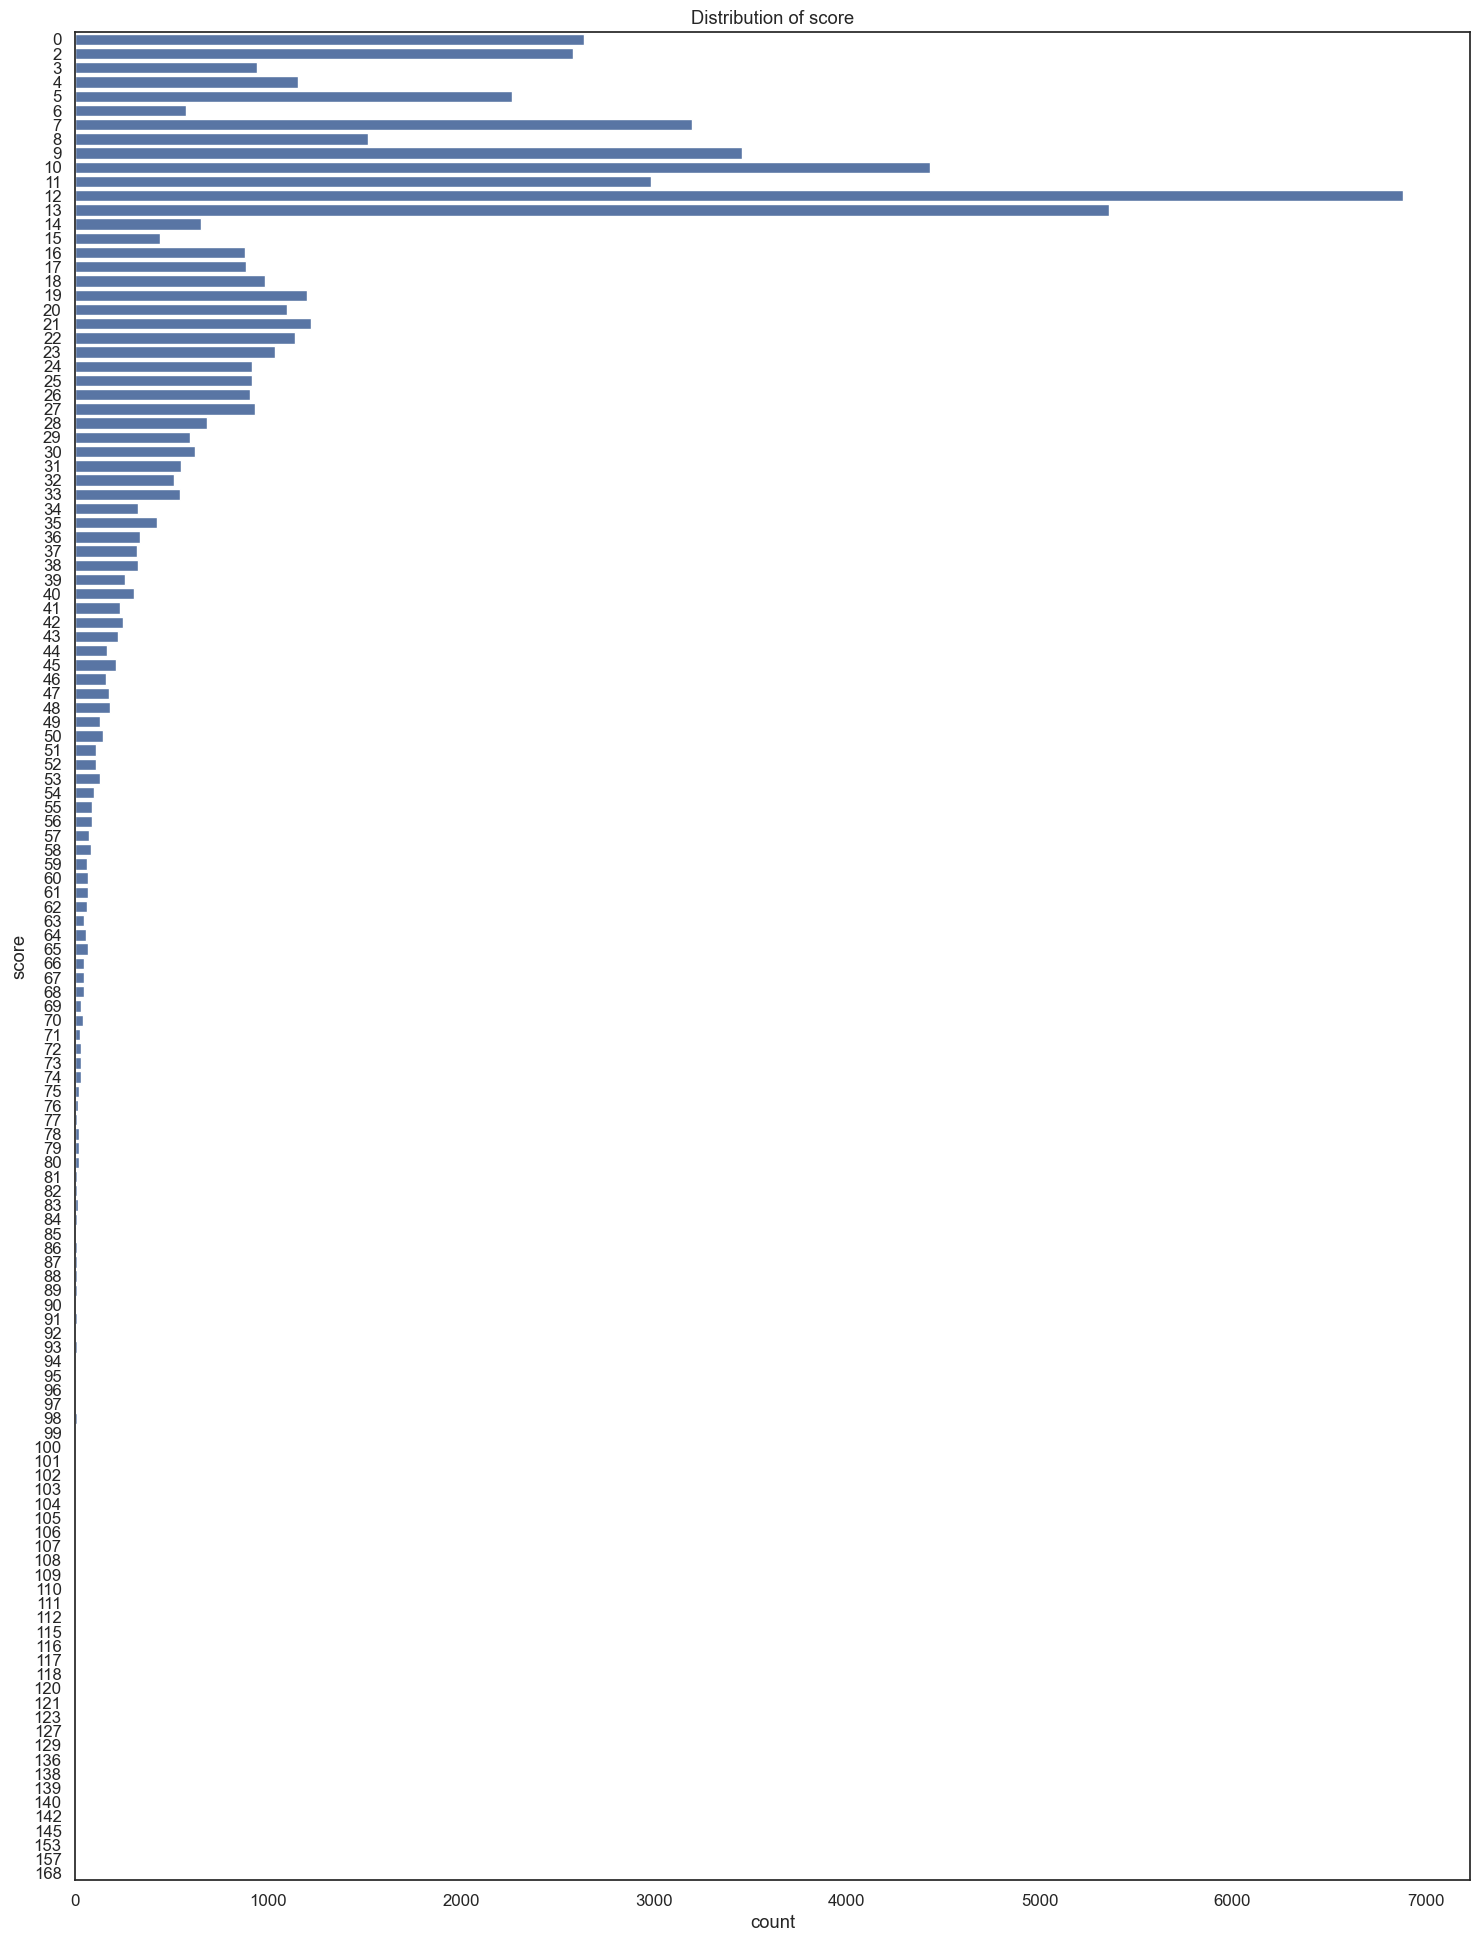

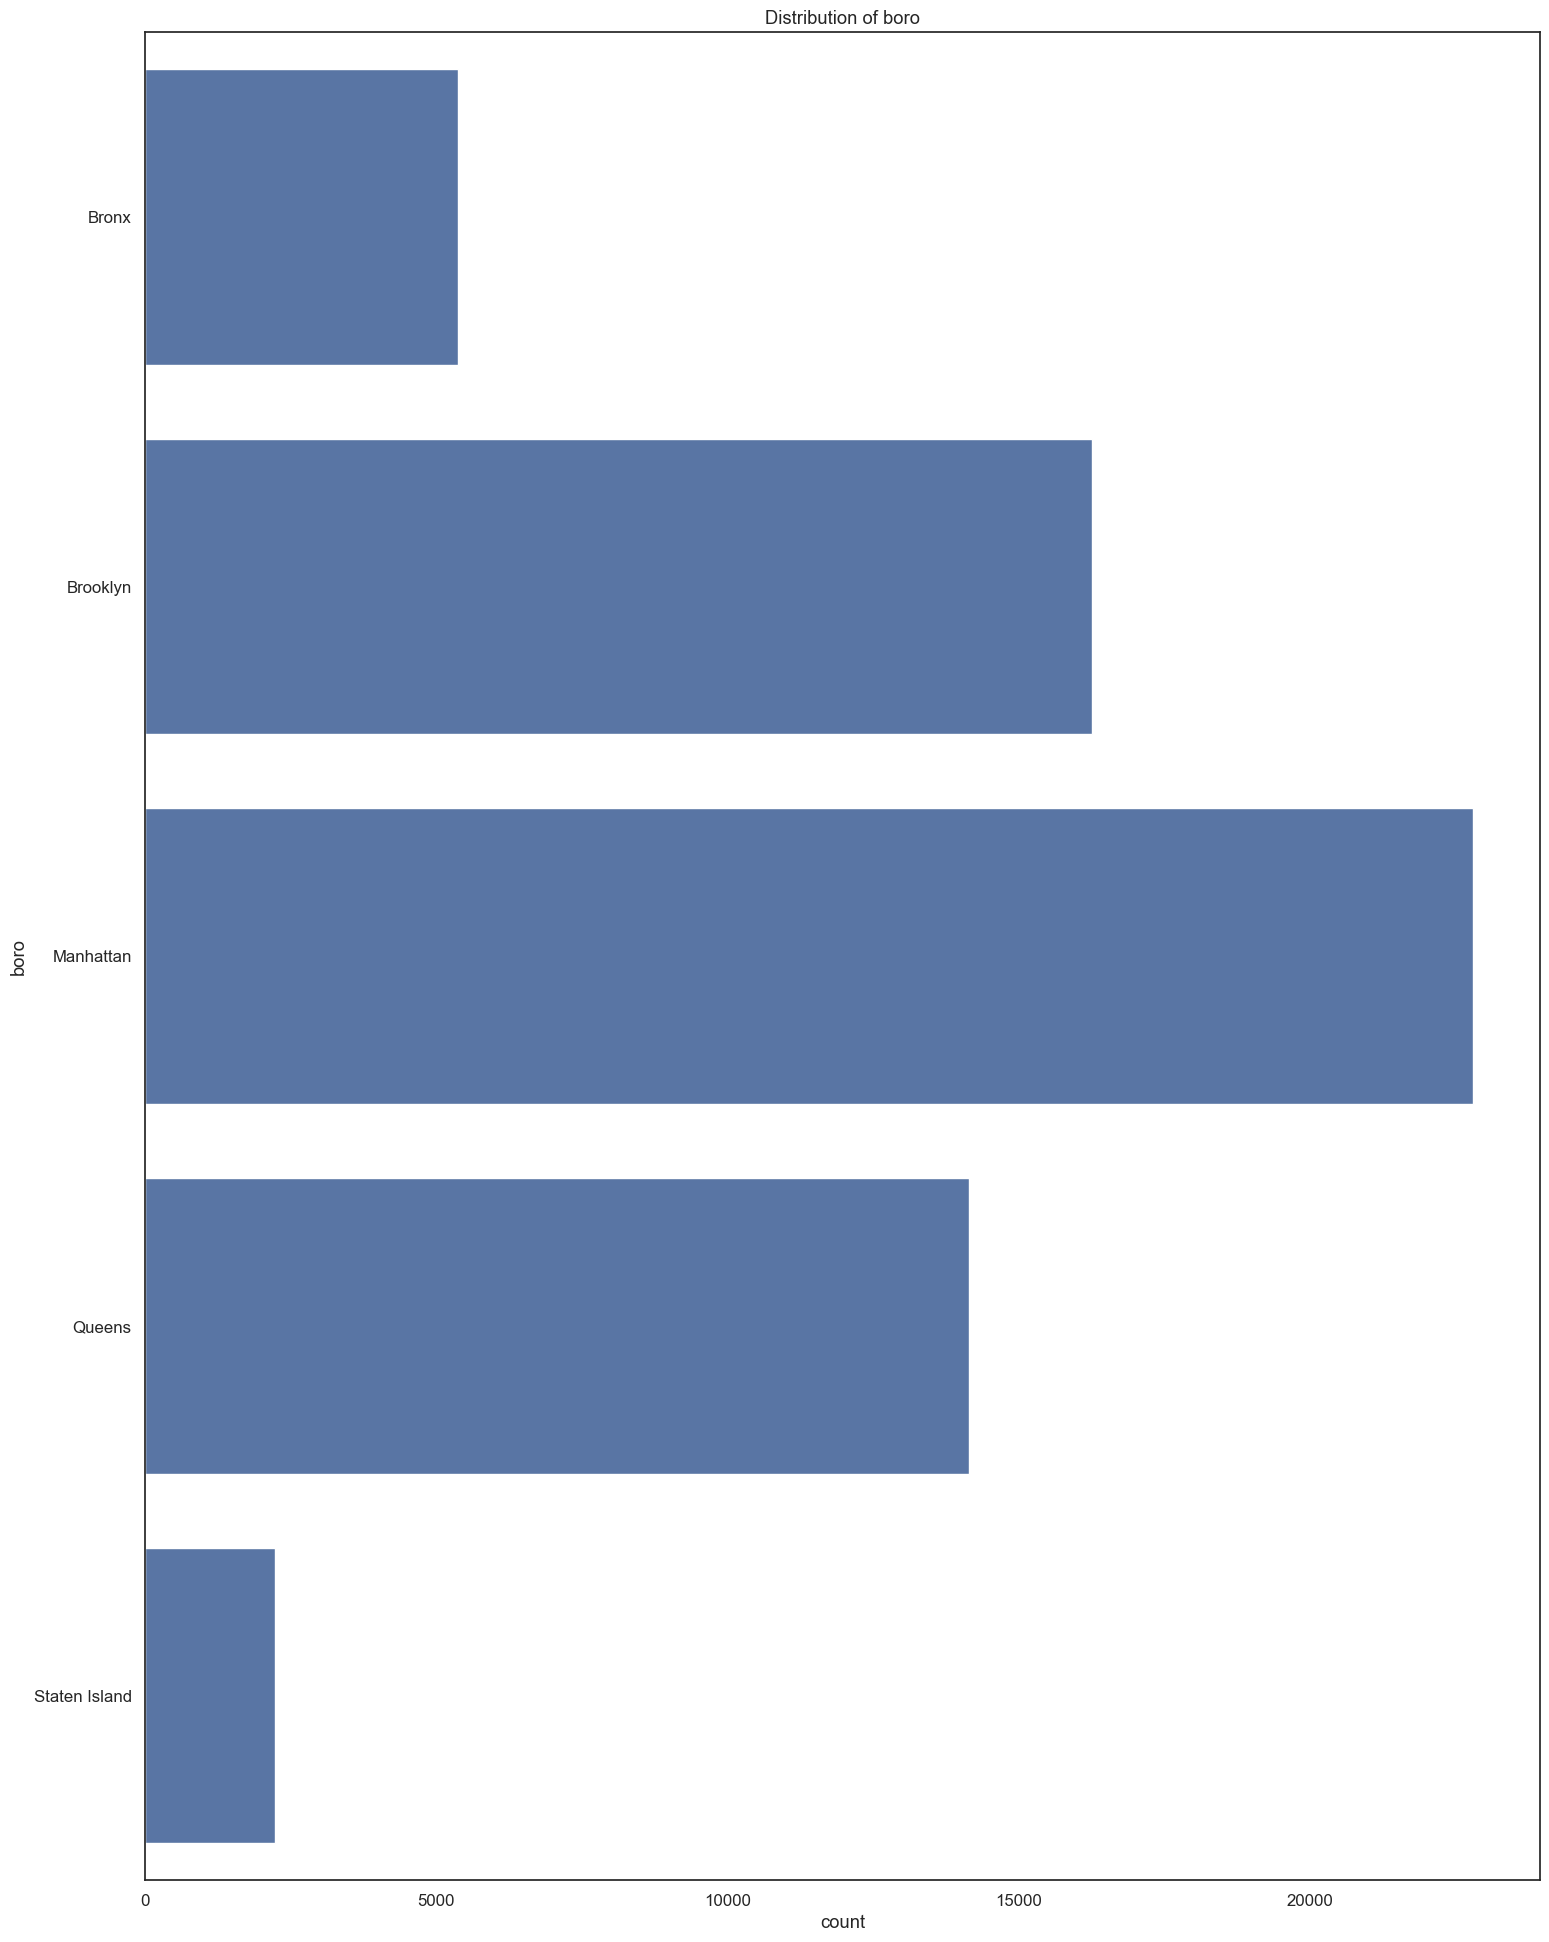

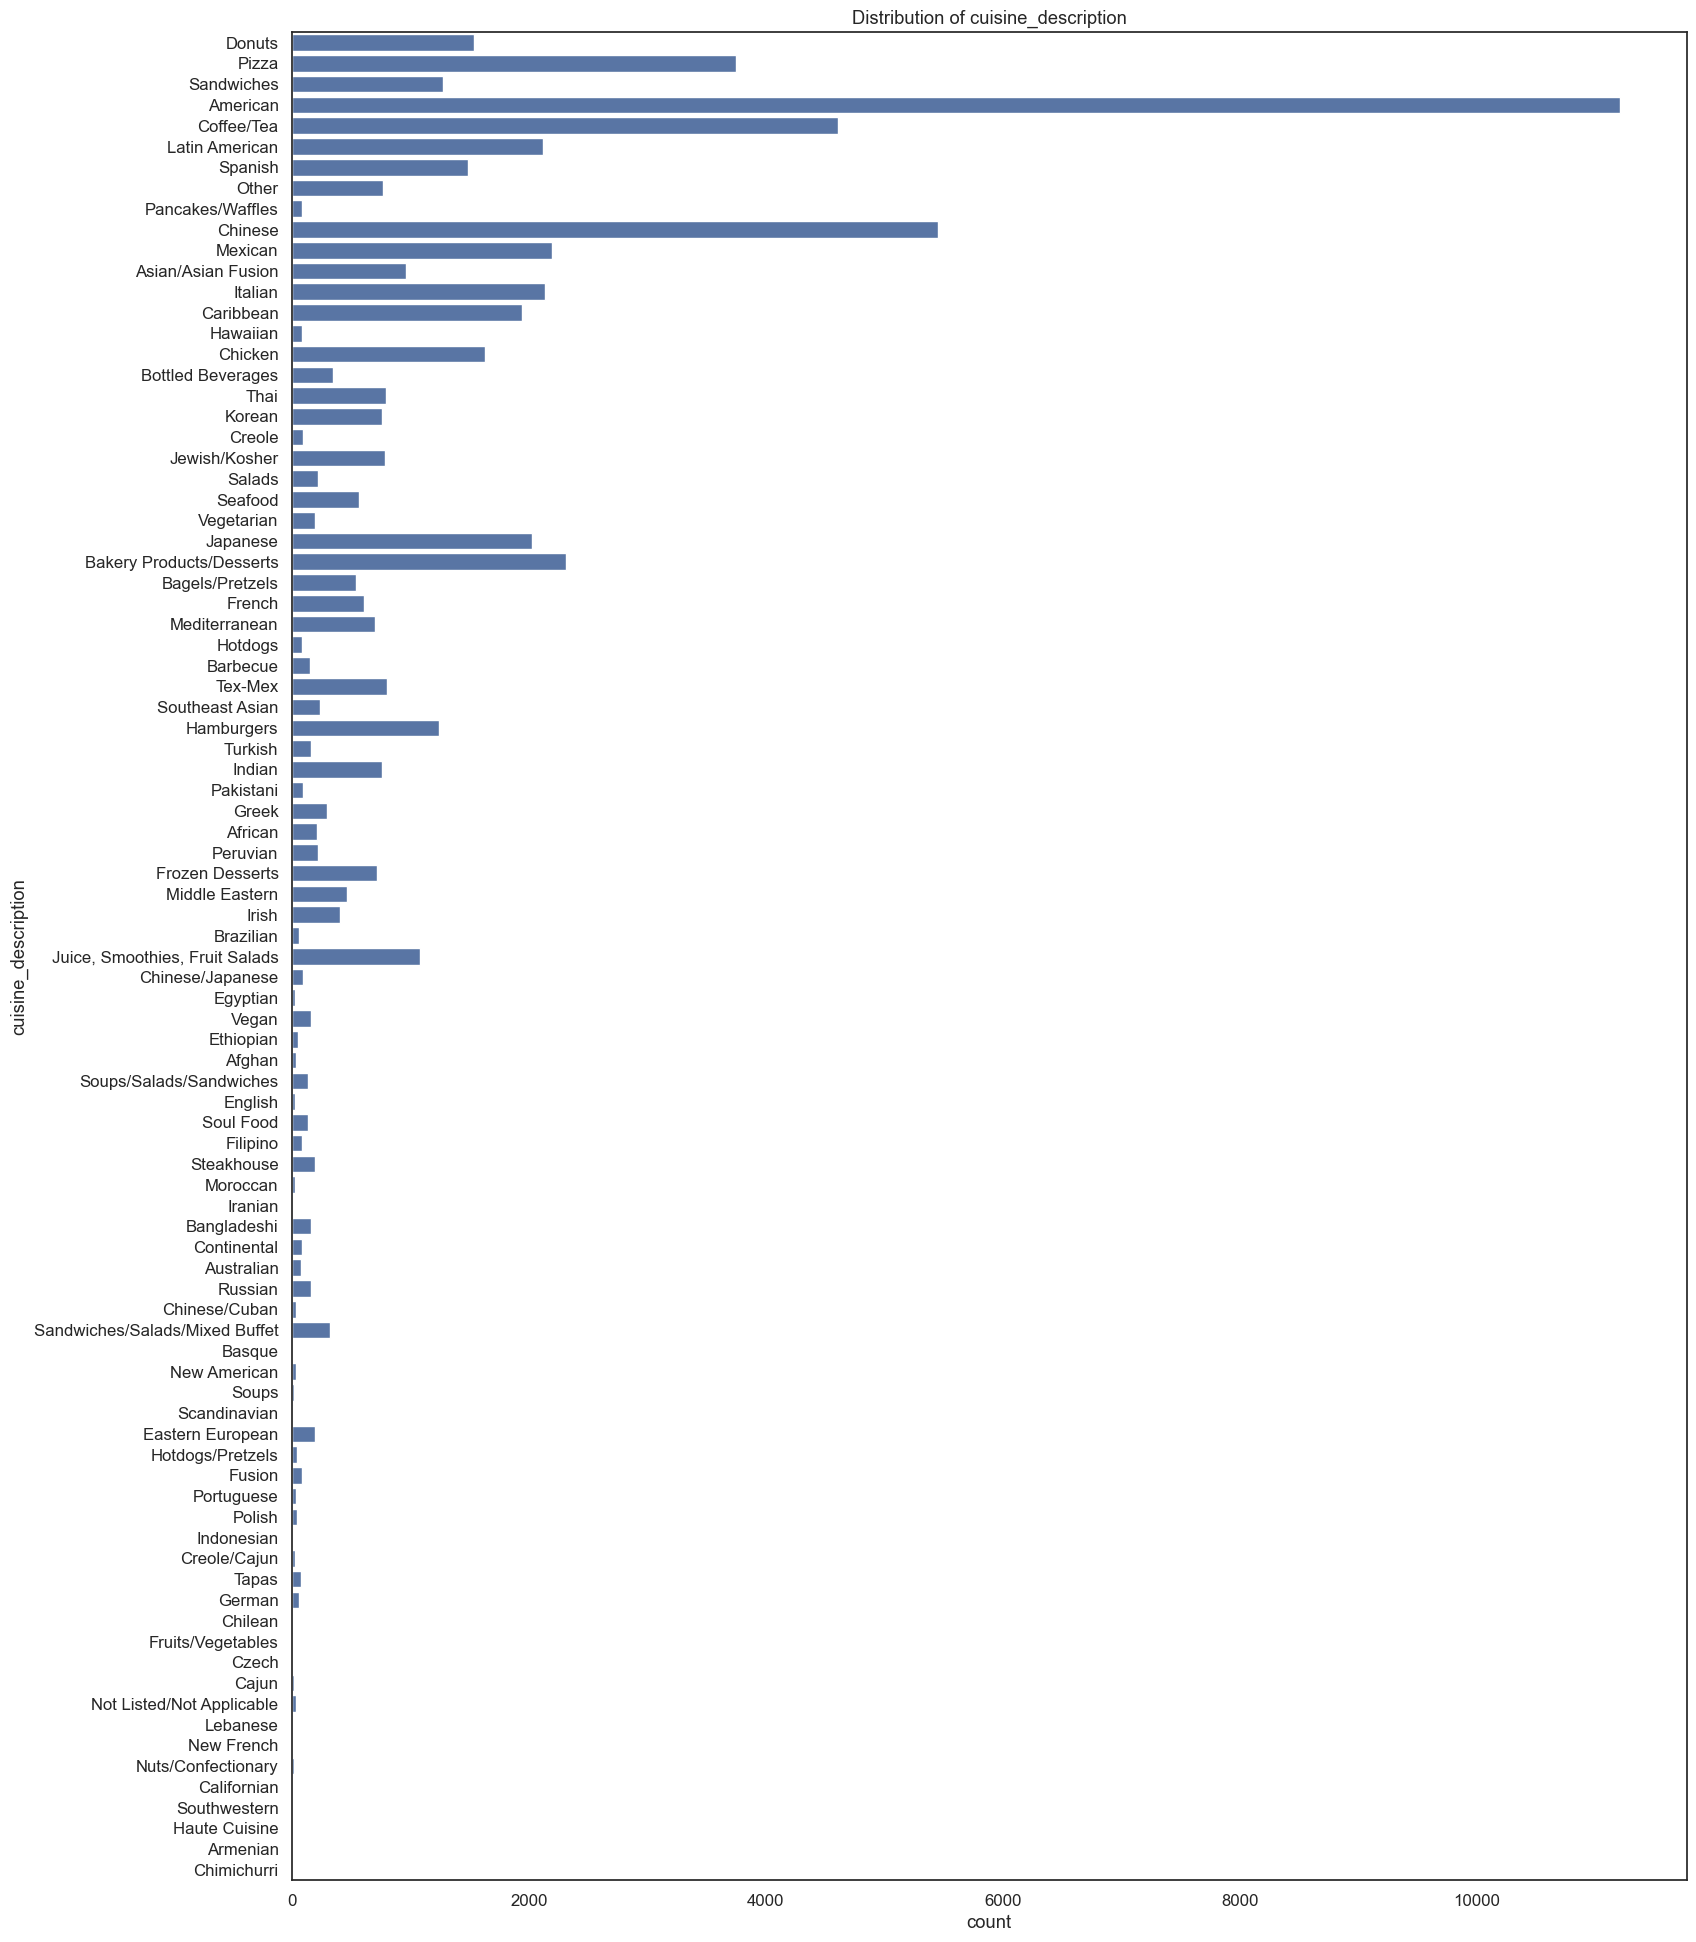

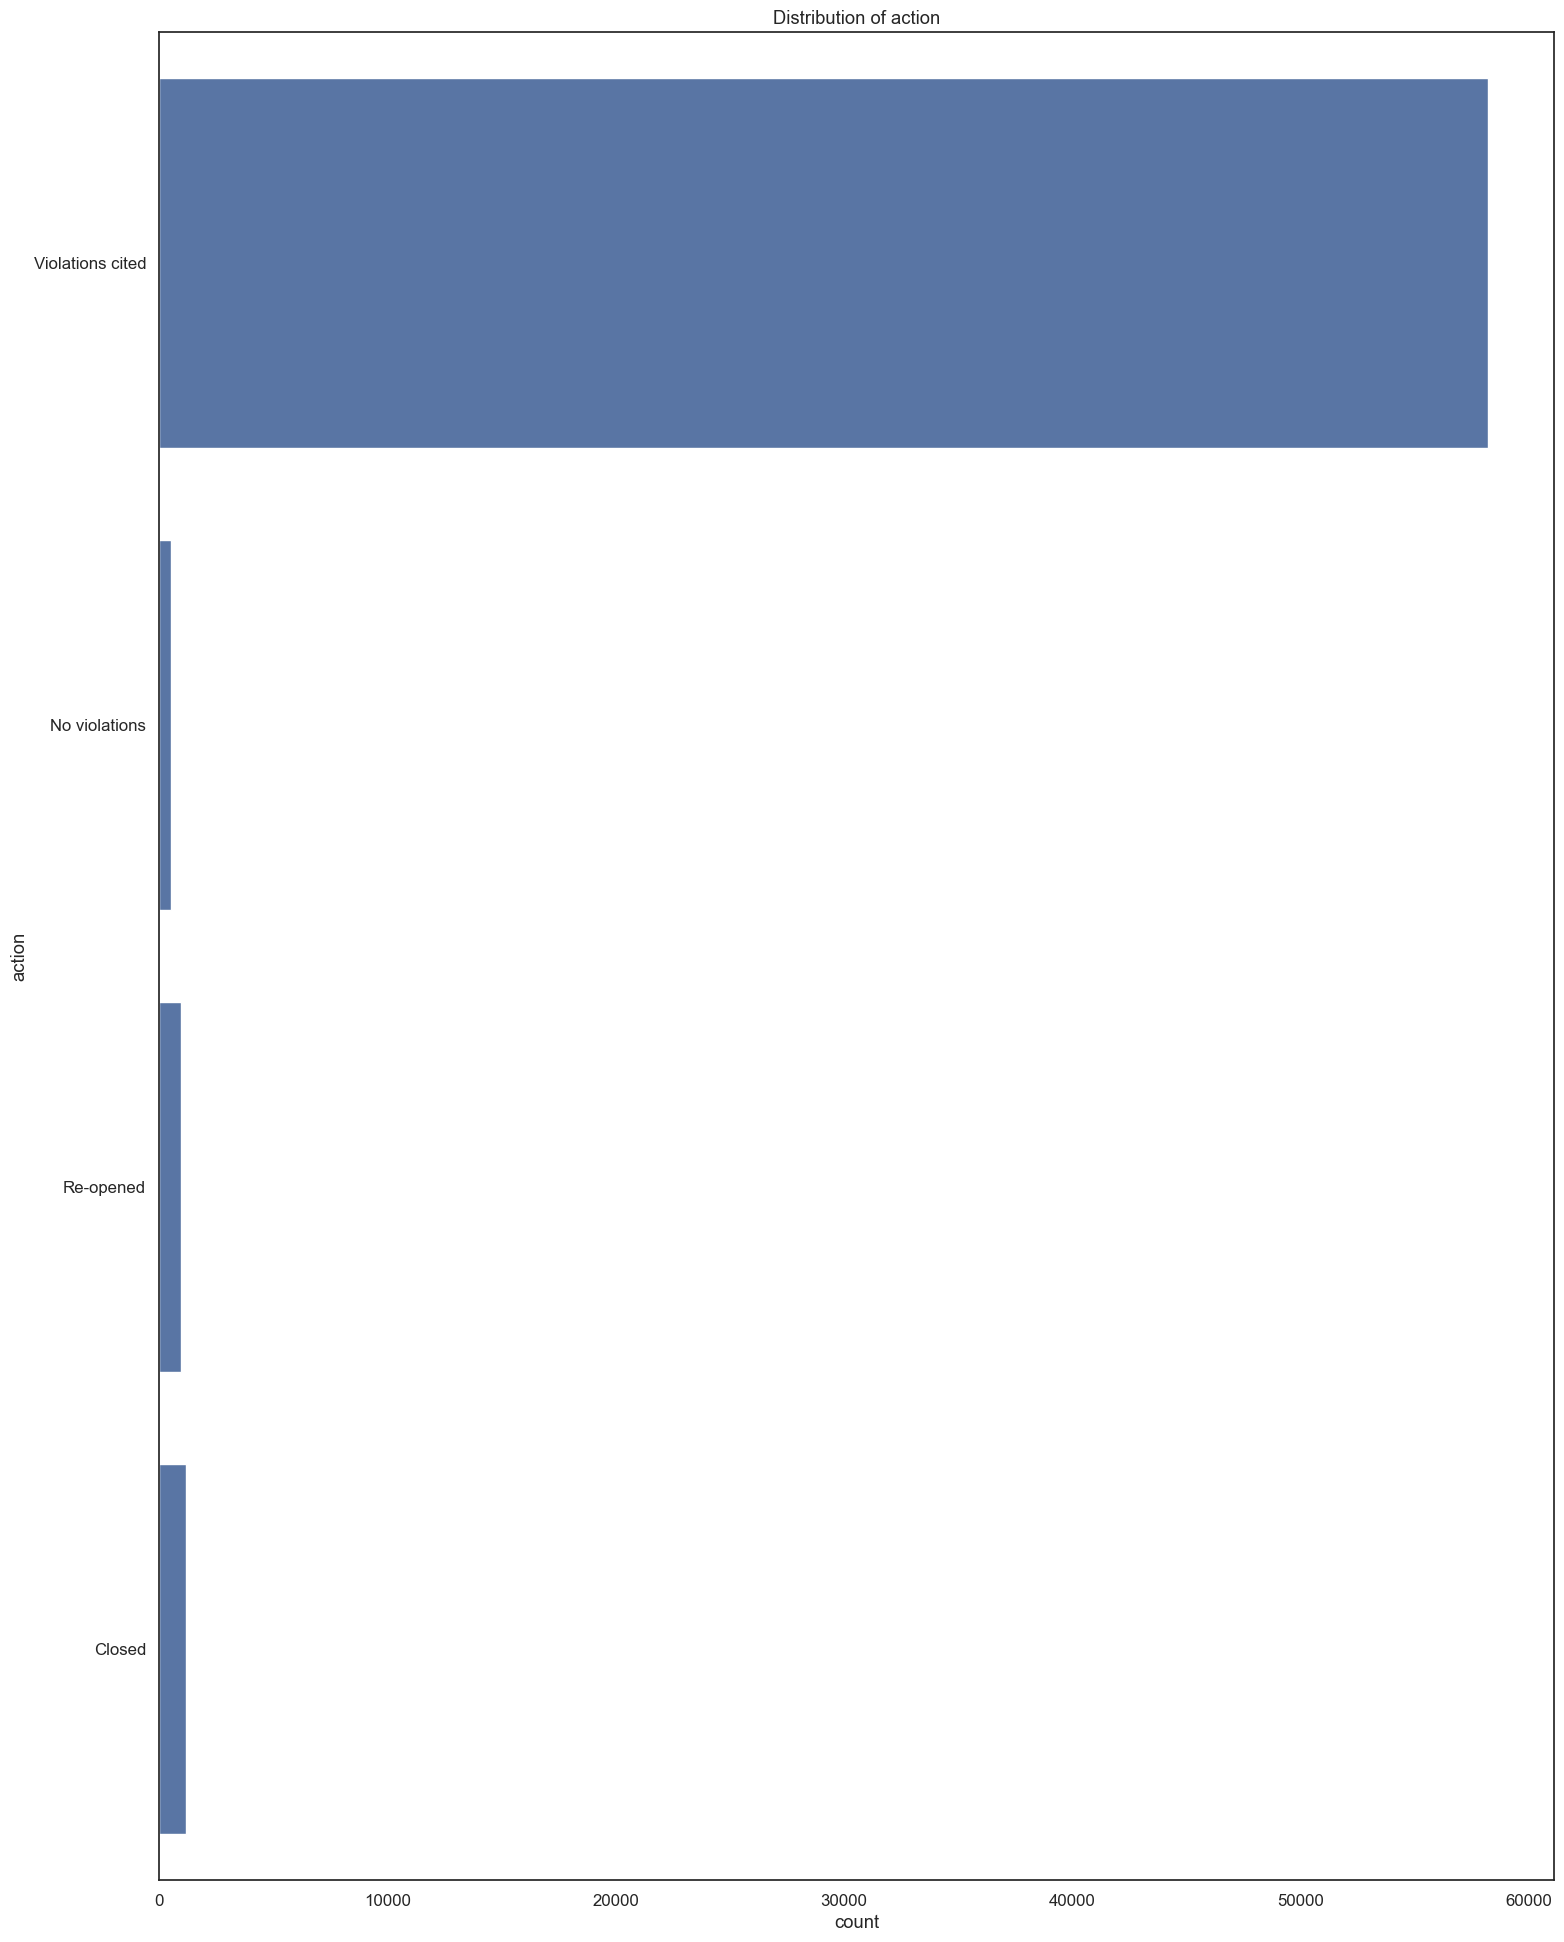

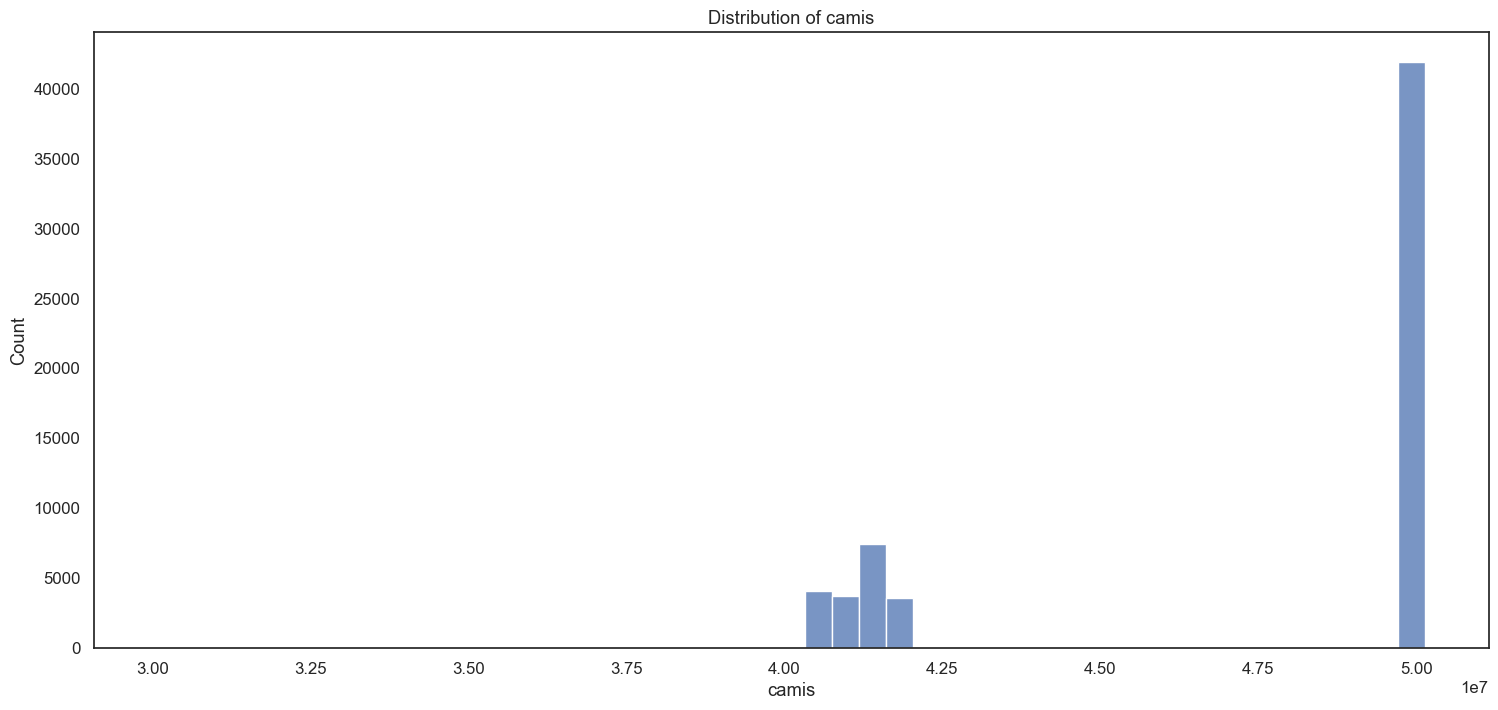

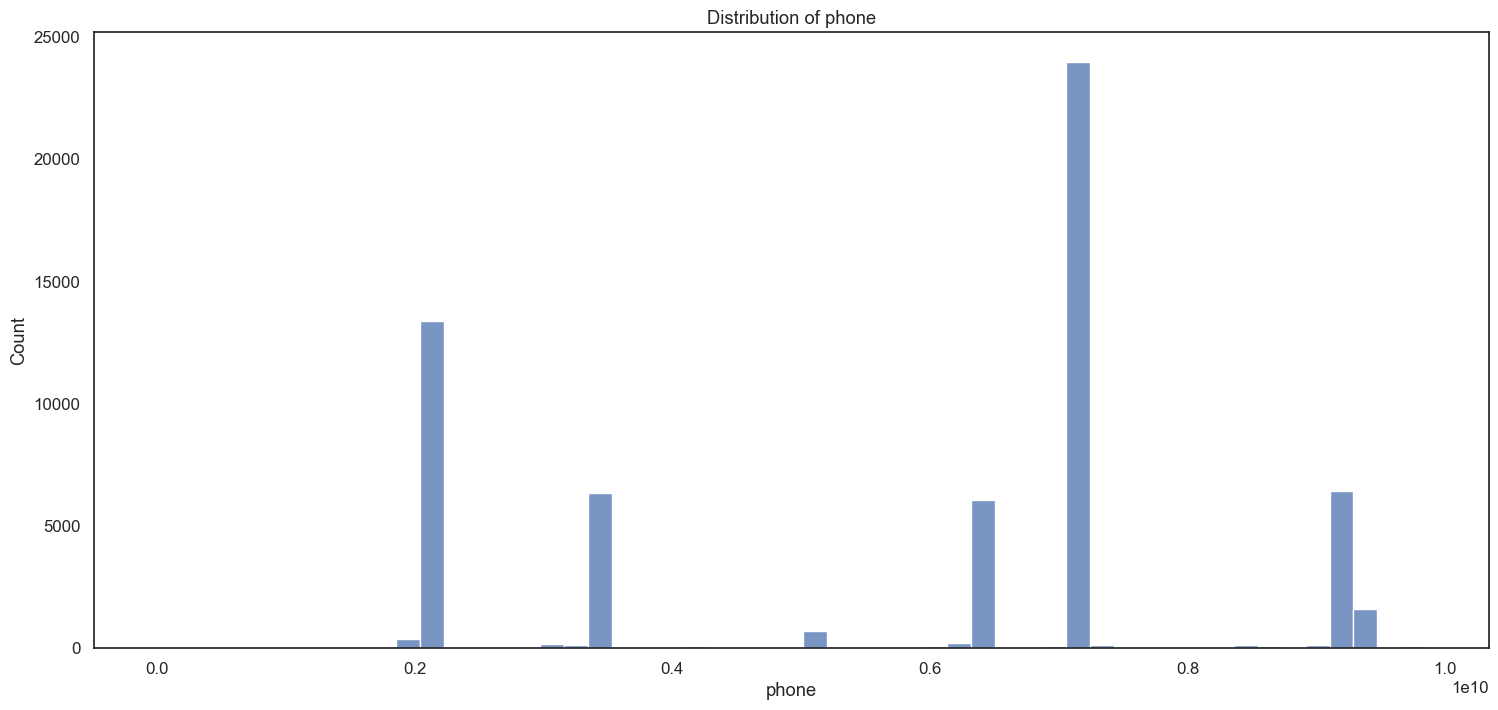

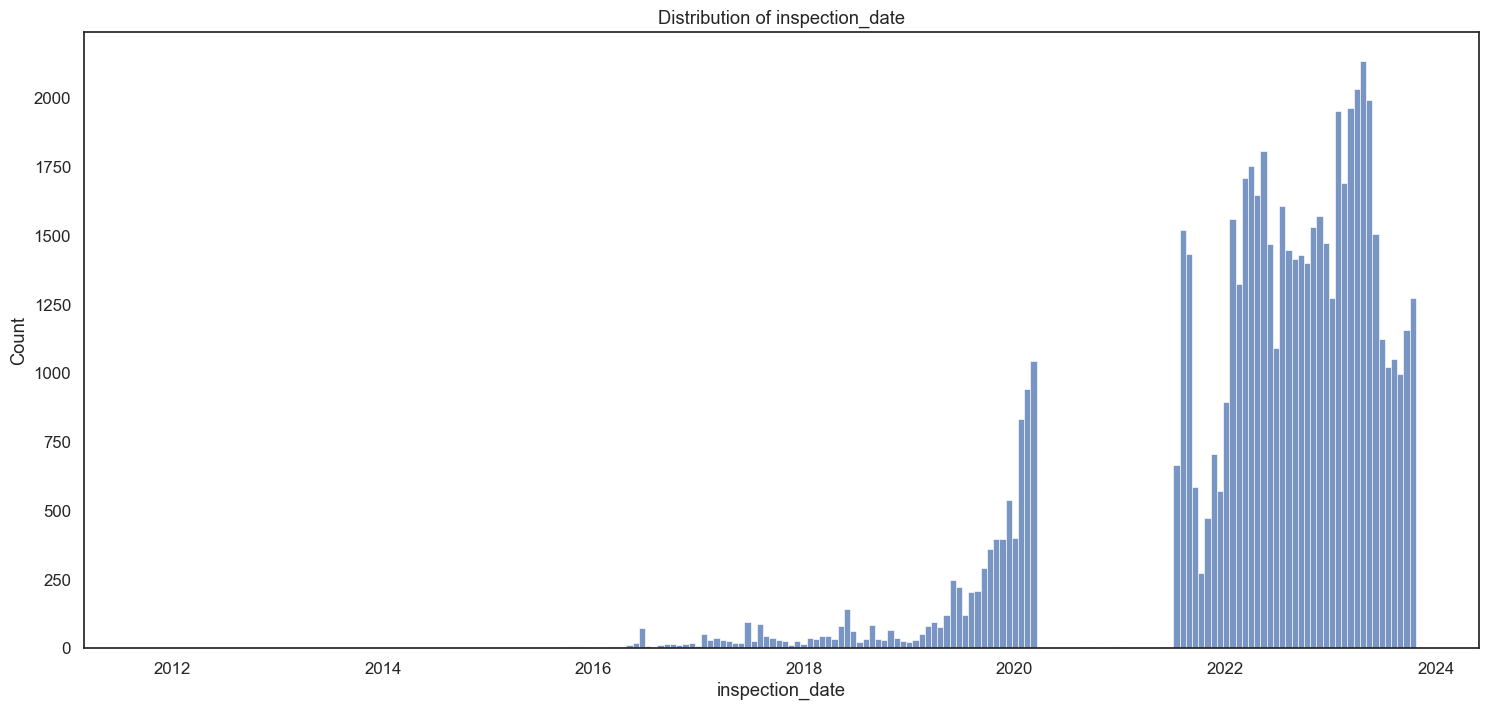

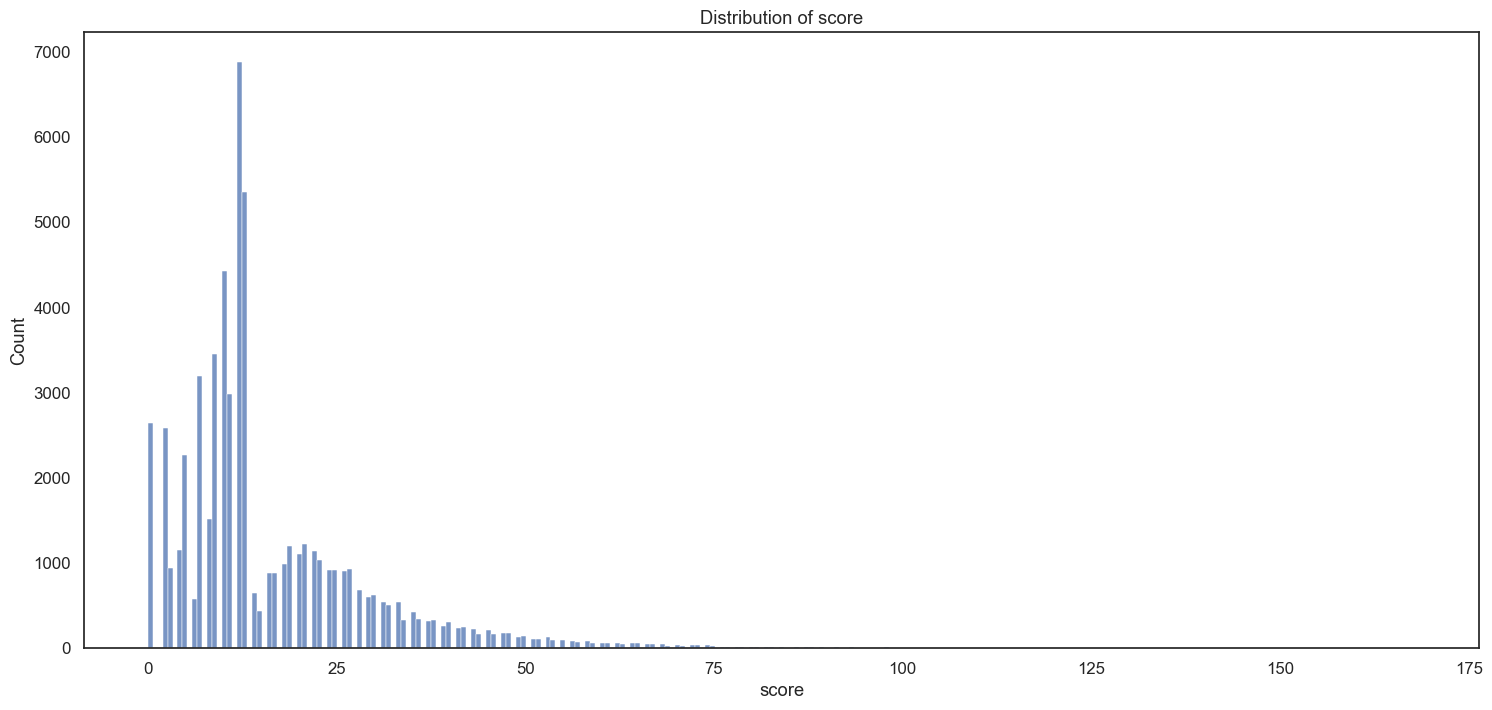

In [40]:
# Should drop 'latitude' and 'longitude'
# flattened_ny = flattened_ny.drop(columns=['latitude', 'longitude'])

sns.set(font_scale=1.10, style="white")

# Define the list of categorical columns
categorical_columns = ['score', 'boro', 'cuisine_description', 'action']

# Define the list of numerical columns
numerical_columns = ['camis', 'phone', 'inspection_date', 'score']

# Visualize categorical features with horizontal bar plots
for column in categorical_columns:
    plt.figure(figsize=(18, 24))  # Adjust the figure size as needed
    sns.countplot(data=ny, y=column)  # Swap x and y axes
    plt.title(f'Distribution of {column}')
    plt.show()

# Visualize numerical features with horizontal bar plots
for column in numerical_columns:
    plt.figure(figsize=(18, 8))
    sns.histplot(data=ny, x=column)
    plt.title(f'Distribution of {column}')
    plt.show()

## Now i will do a pair plot and look at the results for numerical features

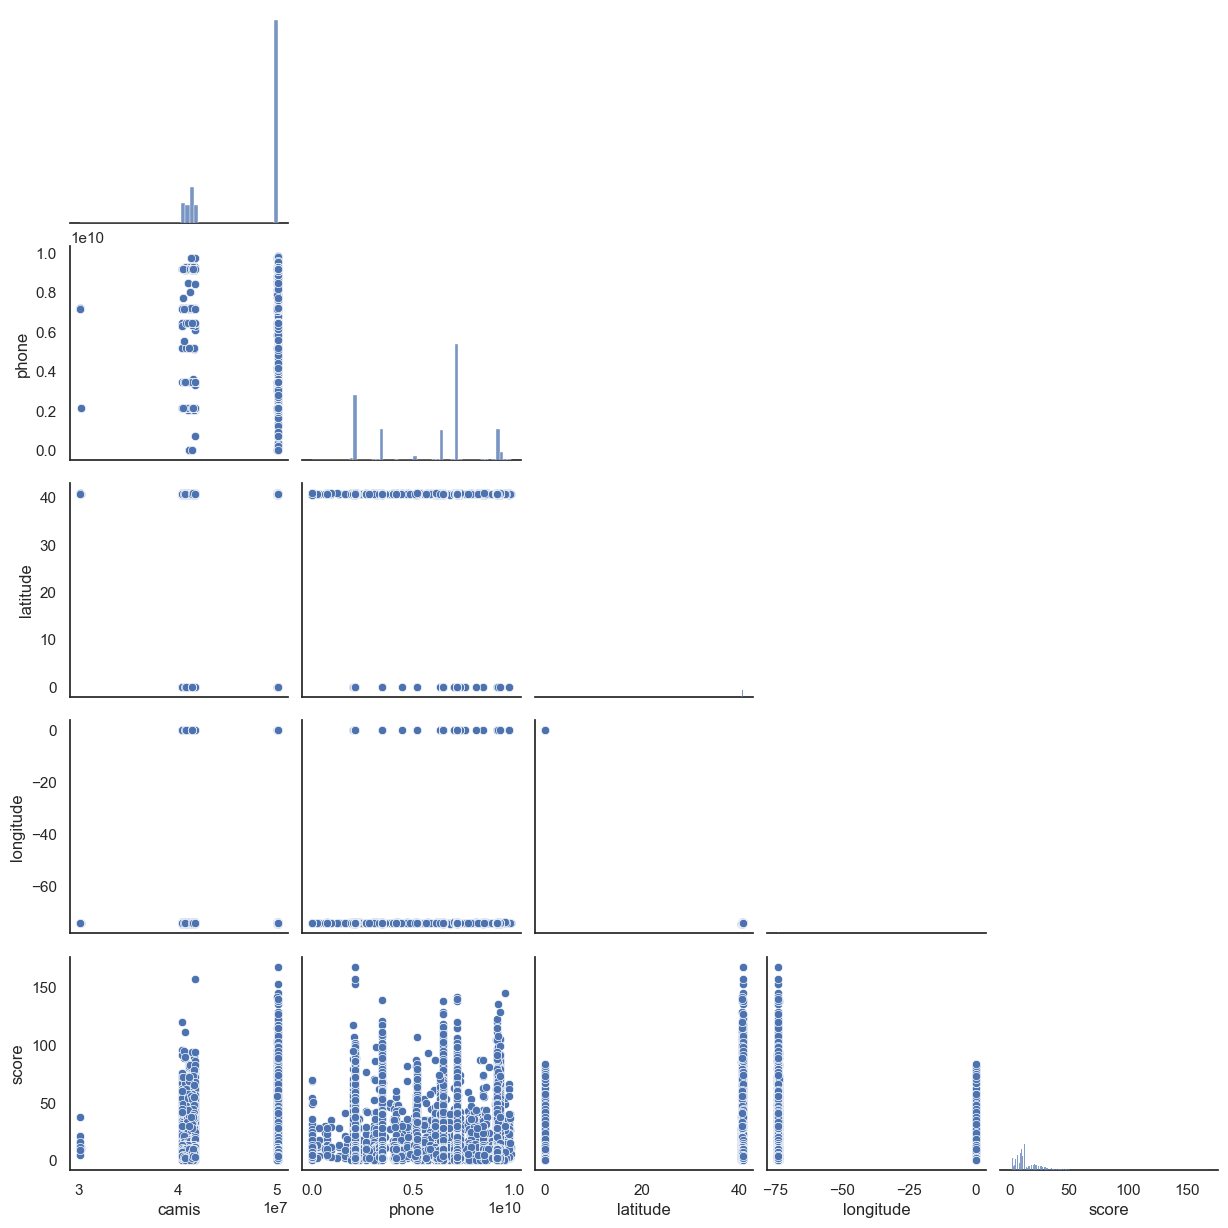

In [41]:
sns.set(font_scale=1, style="white")

sns.pairplot(ny, corner=True)
plt.show()

## Histplot of scores

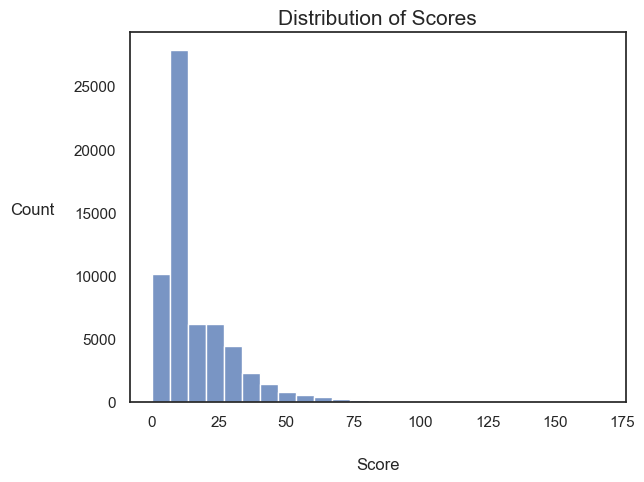

In [23]:
sns.set(font_scale=1, style="white")

sns.histplot(data=ny, x='score', bins=25)
plt.title('Distribution of Scores', fontsize=15)
plt.xlabel('Score', labelpad=20)
plt.ylabel('Count', rotation=0, labelpad=30)
plt.show()

## Histplot of Grades

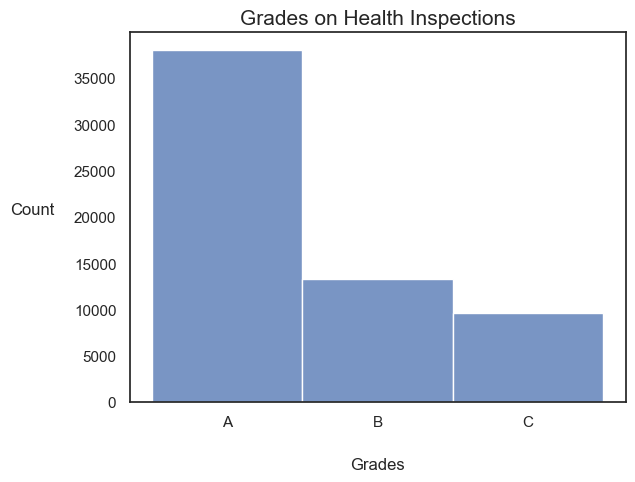

In [24]:
sns.set(font_scale=1, style="white")

sns.histplot(data=ny, x='grade')
plt.title('Grades on Health Inspections', fontsize=15)
plt.xlabel('Grades', labelpad=20)
plt.ylabel('Count', rotation=0, labelpad=30)
plt.show()

## Borough counts

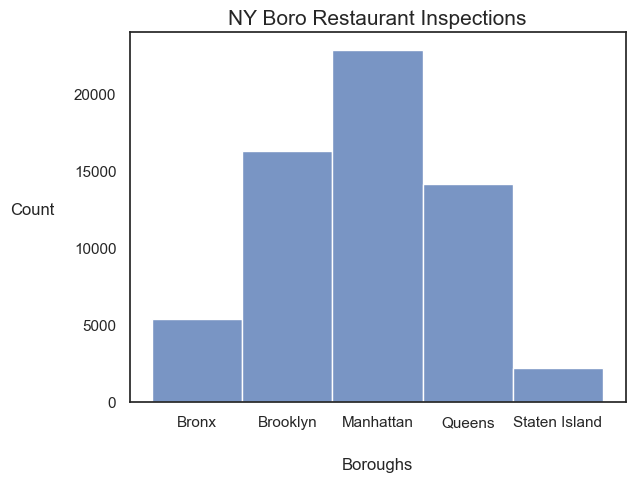

In [25]:
sns.set(font_scale=1, style="white")

sns.histplot(data=ny, x='boro', bins=20)
plt.title('NY Boro Restaurant Inspections', fontsize=15)
plt.xlabel('Boroughs', labelpad=20)
plt.ylabel('Count', rotation=0, labelpad=30)
plt.show()

## observing score and grade relationship; seems that the lower the score the letter grade is closer to A

/var/folders/hz/r10rvhgs41x5bxdmg79hksdw0000gn/T/ipykernel_19938/3539081887.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ny, x ='score', y = 'grade', ci =None)


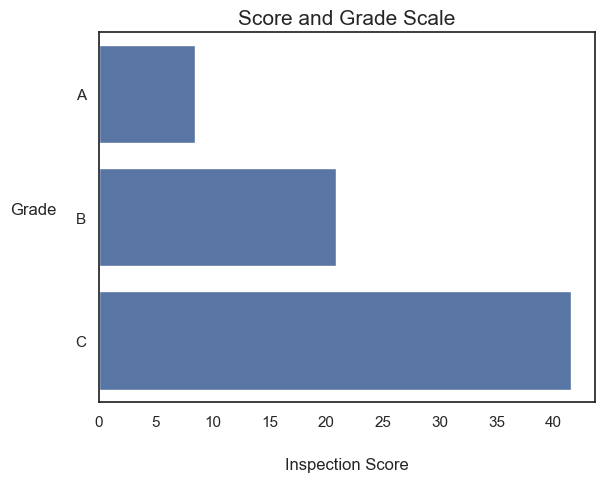

In [26]:
sns.set(font_scale=1, style="white")

sns.barplot(data=ny, x ='score', y = 'grade', ci =None)
plt.title('Score and Grade Scale', fontsize=15)
plt.xlabel('Inspection Score', labelpad=20)
plt.ylabel('Grade', rotation=0, labelpad=30)
plt.show()

## Too many to visual need to bring it down to at least top 20

In [27]:
# business counts
dba_count = ny['dba'].value_counts()
dba_count

dba
DUNKIN                    1036
STARBUCKS                  551
SUBWAY                     530
MCDONALD'S                 444
POPEYES                    269
                          ... 
LATIN KITCHEN                1
JAMAICAN GRILL CUISINE       1
LA CASA DE JULIA             1
KAM SING ONE                 1
EMPLOYEE FEEDING             1
Name: count, Length: 20593, dtype: int64

In [28]:
top_20 = dba_count[0:20]
top_20

dba
DUNKIN                                   1036
STARBUCKS                                 551
SUBWAY                                    530
MCDONALD'S                                444
POPEYES                                   269
BURGER KING                               218
KENNEDY FRIED CHICKEN                     185
DUNKIN'                                   172
CHIPOTLE MEXICAN GRILL                    166
DOMINO'S                                  154
DUNKIN',' BASKIN ROBBINS                  142
GOLDEN KRUST CARIBBEAN BAKERY & GRILL     134
WENDY'S                                   120
CROWN FRIED CHICKEN                       118
TACO BELL                                 109
CARVEL                                     92
KFC                                        90
PRET A MANGER                              90
PAPA JOHN'S                                78
SWEETGREEN                                 73
Name: count, dtype: int64

## Found large chain restaurants as top names for health inspections conducted

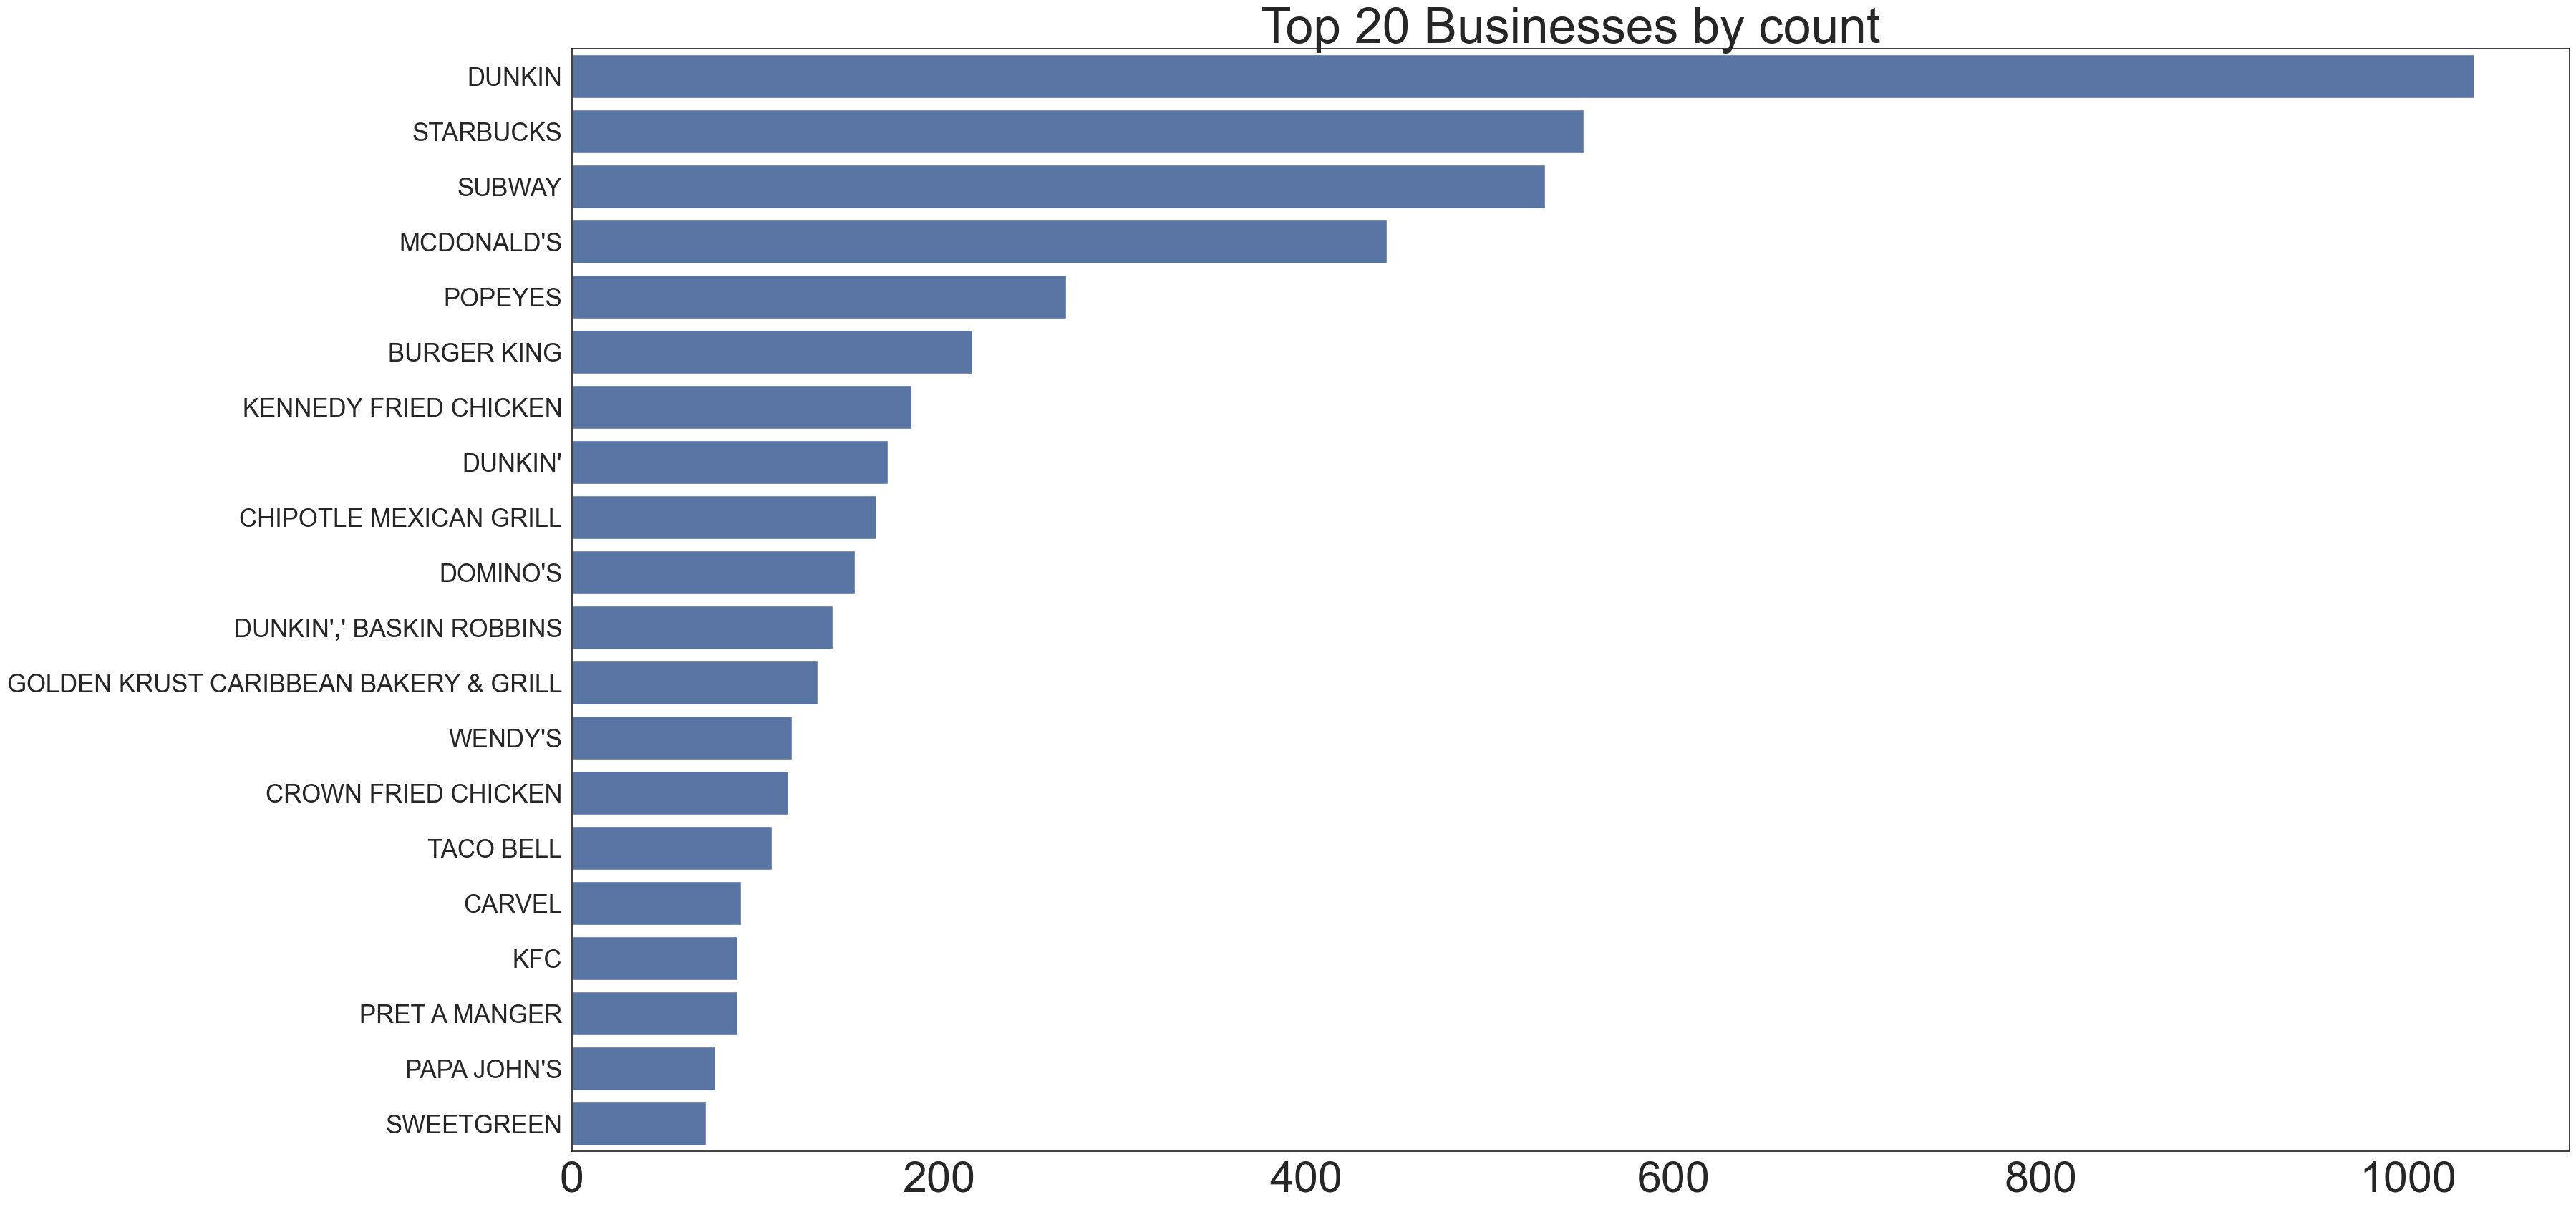

In [29]:
import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=4, style='white')

top_n = 20  # Adjust the number of top values to display

# Create a figure and specify the desired figure size
plt.figure(figsize=(36, 20))

# Create the countplot with y as the 'dba' and x as the count
countplot = sns.countplot(data=ny, y='dba', order=ny['dba'].value_counts().iloc[:top_n].index)

# Increase the font size for the title and y-axis labels
countplot.set_yticklabels(countplot.get_yticklabels(), fontsize=25)  # Adjust the fontsize as needed
plt.title(f'Top {top_n} Businesses by count', fontsize=50)  # Adjust the fontsize as needed
plt.ylabel('')
plt.xlabel('')

plt.show()

## I have hued by grade to see where scores fall

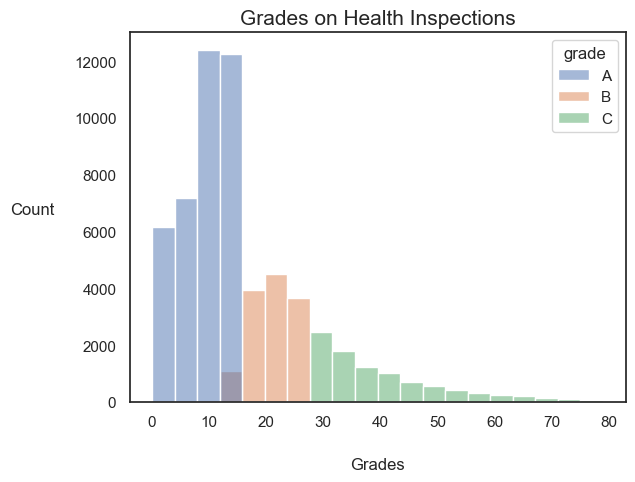

In [30]:
# Set the font scale and style
sns.set(font_scale=1, style="white")

ny_scores = ny[ny.score < 80]
# Create a histogram with a hue variable
sns.histplot(data=ny_scores, x='score', hue='grade', bins=20)
plt.title('Grades on Health Inspections', fontsize=15)
plt.xlabel('Grades', labelpad=20)
plt.ylabel('Count', rotation=0, labelpad=30)
plt.show()

## What was the top cuisine description of inspected restaurants?

In [31]:
ny.cuisine_description.value_counts()

cuisine_description
American                    11210
Chinese                      5454
Coffee/Tea                   4608
Pizza                        3745
Bakery Products/Desserts     2312
                            ...  
Californian                     5
Basque                          3
Armenian                        3
Haute Cuisine                   2
Chimichurri                     1
Name: count, Length: 89, dtype: int64

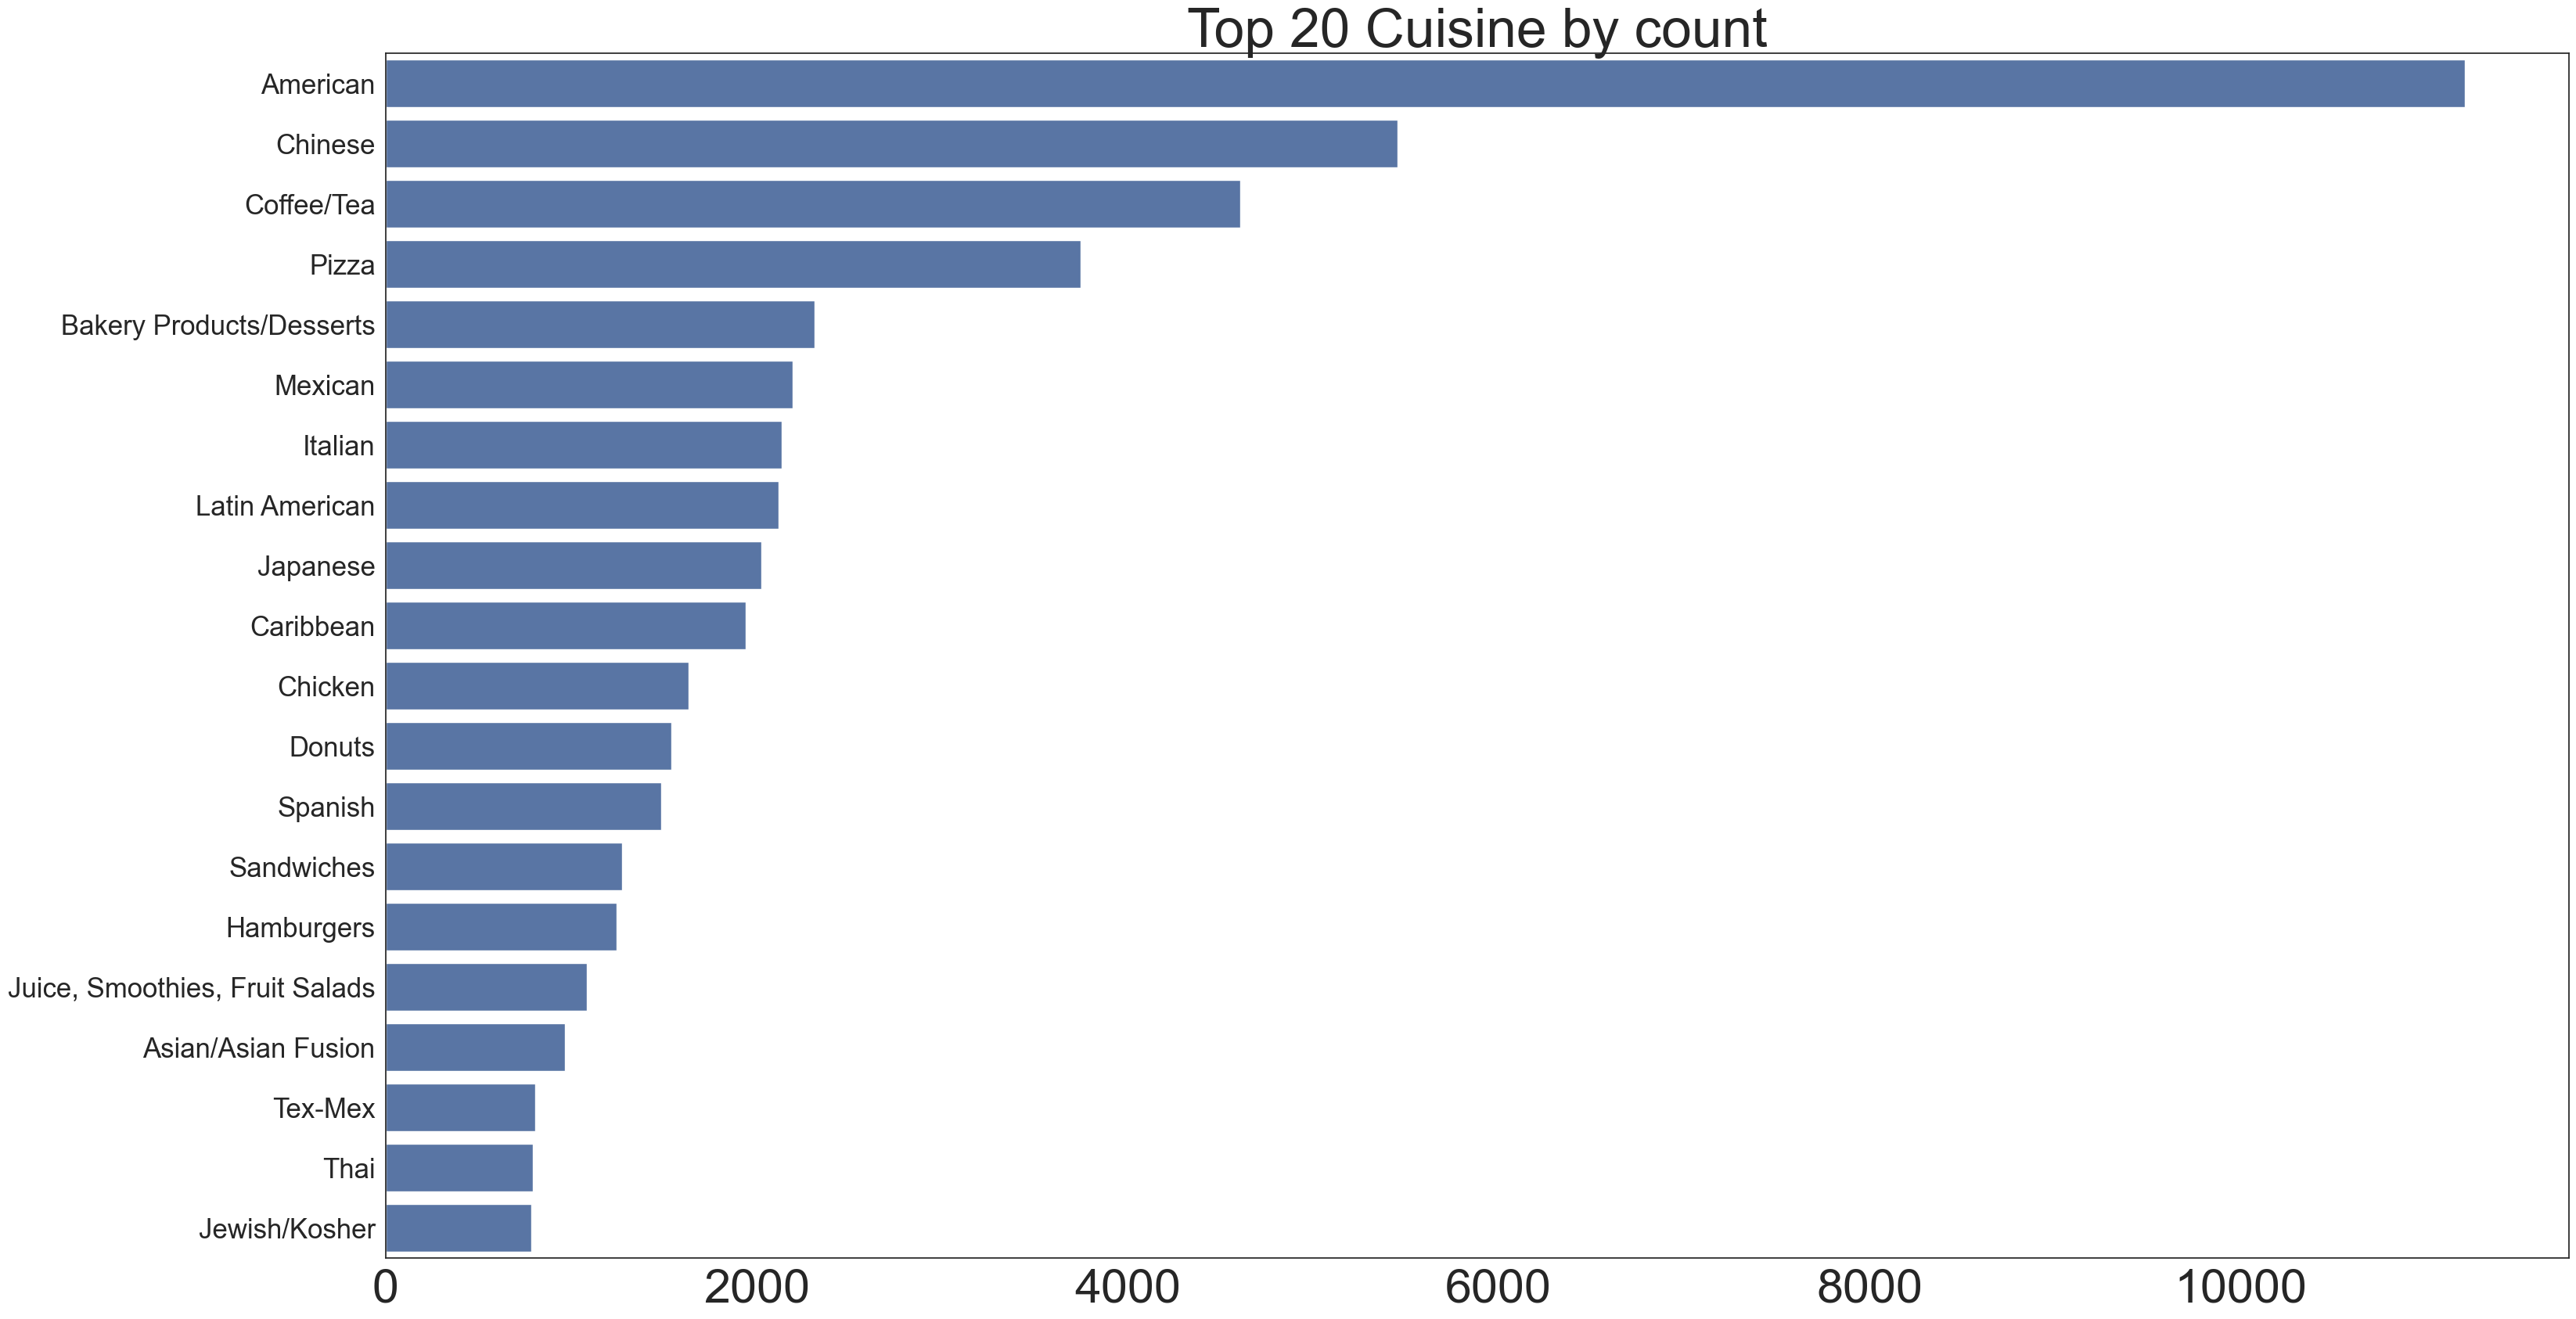

In [32]:
import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=4, style='white')

top_n = 20  # Adjust the number of top values to display

# Create a figure and specify the desired figure size
plt.figure(figsize=(36, 20))

# Create the countplot with y as the 'dba' and x as the count
countplot = sns.countplot(data=ny, y='cuisine_description', order=ny['cuisine_description'].value_counts().iloc[:top_n].index)

# Increase the font size for the title and y-axis labels
countplot.set_yticklabels(countplot.get_yticklabels(), fontsize=25)  # Adjust the fontsize as needed
plt.title(f'Top {top_n} Cuisine by count', fontsize=50)  # Adjust the fontsize as needed
plt.ylabel('')
plt.xlabel('')
plt.show()

## What would grades for the top 20 business in this data be?

In [33]:
top_20_dba = ny['dba'].value_counts().head(20).index
top_20_dba

Index(['DUNKIN', 'STARBUCKS', 'SUBWAY', 'MCDONALD'S', 'POPEYES', 'BURGER KING',
       'KENNEDY FRIED CHICKEN', 'DUNKIN'', 'CHIPOTLE MEXICAN GRILL',
       'DOMINO'S', 'DUNKIN',' BASKIN ROBBINS',
       'GOLDEN KRUST CARIBBEAN BAKERY & GRILL', 'WENDY'S',
       'CROWN FRIED CHICKEN', 'TACO BELL', 'CARVEL', 'KFC', 'PRET A MANGER',
       'PAPA JOHN'S', 'SWEETGREEN'],
      dtype='object', name='dba')

<Figure size 1200x800 with 0 Axes>

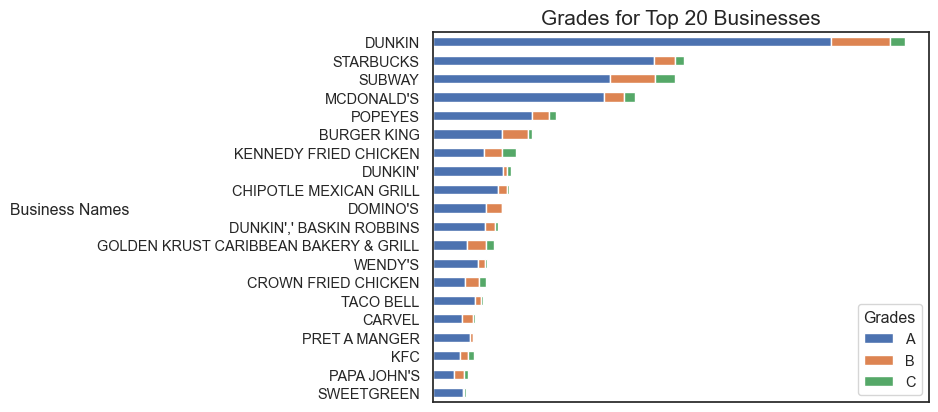

In [34]:
# Set the font scale and style
sns.set(font_scale=0.95, style="white")

# Get the top 20 businesses by counting the "dba" values
top_20_dba = ny['dba'].value_counts().head(20).index

# Filter the data to include only scores less than 80
ny_scores = ny[ny['score'] < 80]

# Group the data by 'dba' and 'grade' and count the occurrences
grouped_data = ny_scores[ny_scores['dba'].isin(top_20_dba)].groupby(['dba', 'grade']).size().unstack(fill_value=0)

# Sort the data by total counts for each business in descending order
sorted_data = grouped_data.sum(axis=1).sort_values(ascending=True).index

# Create a horizontal grouped bar plot with ascending bars
plt.figure(figsize=(12, 8))
ax = grouped_data.loc[sorted_data].plot(kind='barh', stacked=True, legend=False)

plt.title('Grades for Top 20 Businesses', fontsize=15)
plt.ylabel('Business Names', rotation=0, labelpad=20)
plt.xlabel( '', rotation=0, labelpad=20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are offplt.legend()
plt.legend(title='Grades')
plt.show()

## What were the top 5 highest violation codes counted?

In [35]:
codes_column

NameError: name 'codes_column' is not defined

In [ ]:
# Initialize an empty list to store the split codes
split_codes_list = []

# Access the column with the codes
codes_column = ny['violation_code']

# Split the codes and append them to the list
for codes in codes_column:
    
    if codes == 'No violation':
        split_codes_list.append(codes)
        
    else:
        split_codes = codes.split(' ')
        
        split_codes_list.extend(split_codes)


# Now, split_codes_list contains all the split codes

# You can print the list to verify the results
print(split_codes_list)

In [ ]:
violation_code_series = pd.Series(split_codes_list)
violation_code_series.value_counts()

In [ ]:
violation_counts = violation_code_series.value_counts().reset_index()
violation_counts.columns = ['Violation Code', 'Count']

plt.figure(figsize=(12, 15))
sns.set(font_scale=1, style="white")
sns.barplot(data=violation_counts, x='Count', y='Violation Code')
plt.xlabel('Count')
plt.ylabel('Violation Code')
plt.title('Count of Violation Codes')
plt.show()

## The most occurring violation code in out data was 10F, here are what the violations were:
* Flooring improperly constructed and/or maintained
* Non-food contact surfaces (wall, ceiling, floors) improperly constructed/maintained
* Non-food contact surface (fixtures, decorative material, fans, etc.) not properly maintained or equipment not properly maintained

## Scatterplot of score vs. inspection date 

In [ ]:
# Convert inspection_date to datetime
ny['inspection_date'] = pd.to_datetime(ny['inspection_date'])

sns.set(font_scale=0.95, style="white")
sns.scatterplot(data=ny, x='score', y='inspection_date')
plt.xlabel('Score', labelpad=20)
plt.ylabel('Years')
plt.title('Scatterplot of Score vs. Inspection Date')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are offplt.legend()
plt.show()

## Scatterplot of actions outcomes based on score and inspection dates.

In [ ]:
# Convert inspection_date to datetime
ny['inspection_date'] = pd.to_datetime(ny['inspection_date'])

sns.set(font_scale=0.95, style="white")
sns.scatterplot(data=ny, x='score', y='inspection_date', hue='action')
plt.xlabel('Score', labelpad=20)
plt.ylabel('Years')
plt.title('Scatterplot of Score vs. Inspection Date')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are offplt.legend()
plt.show()

# Data Modeling